In [1]:
import sys, os

HOME_PATH = '/home/vvieira'
sys.path.extend([os.path.join(HOME_PATH,pkg,'src') for pkg in ('cobamp','troppo','human_ts_models/shared')])
os.chdir(os.path.join(HOME_PATH,'human_ts_models'))

In [2]:
import cobamp
import troppo
import pandas as pd
from models import get_human1_model

COBRAModelObjectReader is available for cobra
FramedModelObjectReader is available for reframed
FramedModelObjectReader could not be loaded for reframed
Python 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0] on linux


/home/vvieira/cobamp/src/cobamp/wrappers/external_wrappers.py:12 UserWarning: 
The wrappers.external_wrappers module will be deprecated in a future release in favour of the wrappers module. 
    Available ModelObjectReader classes can still be loaded using cobamp.wrappers.<class>. An appropriate model 
    reader can also be created using the get_model_reader function on cobamp.wrappers


In [3]:
PRJ_FOLDER = 'projects/ccle_models'
RES_FOLDER = os.path.join(PRJ_FOLDER,'results/human1/reconstructions/ccle_mcf7_params/')

In [4]:
hgnc_df = pd.read_csv('ftp://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/non_alt_loci_set.txt', sep='\t',index_col=0)
hgnc_df['entrez_id'] = hgnc_df['entrez_id'].fillna(-1).astype(int)

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063 DtypeWarning: Columns (32,34,38,40,50) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
sample_info = pd.read_csv('https://ndownloader.figshare.com/files/21522000', index_col=0)

In [6]:
PREFIX_STR = 'best_params_run_mapall.csv_biomass_gapfill_gapfill_map'

model_df_pre_gapfill = pd.read_csv(os.path.join(RES_FOLDER,'best_params_run_mapall.csv'), index_col=[0,1,2])
model_df_post_gapfill = pd.concat([
    pd.read_csv(os.path.join(RES_FOLDER,PREFIX_STR+str(i)+'.csv'), index_col=[0,1,2]) for i in (1,2)])

In [7]:
import cobra
from cobra.io import read_sbml_model
from cobra.flux_analysis.variability import find_blocked_reactions

cobra.Configuration.solver = cobra.util.solvers['cplex']

from urllib.request import urlretrieve

path = 'shared/models/Human-GEM_latest_consistent.xml'
cobra_model = read_sbml_model(path)

# for r in [r for r in cobra_model.reactions if 'biomass' in r.id]:
#     r.bounds = (0, 0)

cobra_model.reactions.get_by_id('biomass_human').bounds = (0, 1000)
# cobra_model.remove_reactions(find_blocked_reactions(model))


#cobra_model = get_human1_model()
pathway_mapping = {g.name:[r.id for r in g.members] for g in cobra_model.groups}

In [8]:
cobra_model.reactions.get_by_id('HMR_4865')

<Reaction HMR_4865 at 0x7f01a0720908>

In [9]:
from itertools import chain

all_reactions = [r.id for r in cobra_model.reactions]
meta_reacs = {sub:set(chain(*[set(m.id for m in cobra_model.reactions.get_by_id(r).metabolites.keys()) for r in reacs if r in all_reactions])) for sub,reacs in pathway_mapping.items() }
drugs_from_exchange = meta_reacs['Drug metabolism'] & meta_reacs['Exchange/demand reactions'] - set(chain(*[v for k,v in meta_reacs.items() if k not in ['Drug metabolism', 'Exchange/demand reactions']]))
reactions_drugs_from_exchange = [r.id for r in cobra_model.boundary if len(set([m.id for m in r.metabolites]) & drugs_from_exchange) > 0]



In [10]:
model_df_post_gapfill[reactions_drugs_from_exchange] = False

In [11]:
pre_gapfill_percs = pd.DataFrame({k: model_df_pre_gapfill[v].sum(axis=1)/len(v) for k,v in pathway_mapping.items()}).fillna(0)
post_gapfill_percs = pd.DataFrame({k: model_df_post_gapfill[v].sum(axis=1)/len(v) for k,v in pathway_mapping.items()}).fillna(0)

pre_gapfill_percs['cell_line'] = [k[1].split('_')[0] for k in pre_gapfill_percs.index]
post_gapfill_percs['cell_line'] = [k[1].split('_')[0] for k in post_gapfill_percs.index]

In [12]:
from cobamp.wrappers import ConstraintBasedModelSimulator
from cobamp.wrappers.cobra import cobra_simulation_result_function, cobra_simulate
from cobra.flux_analysis import pfba

SIM_PATH = 'pfba_ccle_model_analysis_no_drug.csv'

if not os.path.exists(SIM_PATH):
    cbm_simulator = ConstraintBasedModelSimulator(cobra_model, cobra_simulate, cobra_simulation_result_function)

    bcgs = [{k:(0,0) for k,v in row.to_dict().items() if not v} for i, row in model_df_post_gapfill.iterrows()]

    pfba_sims = cbm_simulator.batch_simulate(pfba, bcgs, [{'biomass_human': 1}], [False])
    pfba_sims_df = pd.DataFrame(dict(zip(model_df_post_gapfill.index, 
                                         [pd.Series(fluxes) for opt, ofv, fluxes in pfba_sims]))).T

    del pfba_sims
    pfba_sims_df.to_csv(SIM_PATH)

else:
    pfba_sims_df = pd.read_csv(SIM_PATH, index_col=[0,1,2])

In [13]:
from numpy import log10, abs as npabs, e

def logscale(x):
    sign = x/npabs(x)
    return log10(npabs(x+sign))*sign

def sigmoid(x,a,k,i):
    return a*(k/(k+e**(i*x))) + 1
    
sigmoid_saturation = 0.05
def normalize_sigmoid(x):
    return sigmoid(x, -2, 1, sigmoid_saturation)

pfba_sims_df_scl = logscale(pfba_sims_df).fillna(0)
#pfba_sims_df_scl['disease_sub'] = pfba_cl_features['disease'] + ' ' + pfba_cl_features['disease_subtype']

In [14]:
forward_flux = pfba_sims_df_scl.copy().clip(0, 1000).abs()
reversibles = (pfba_sims_df_scl < 0).any(axis=0)
rev_indices = reversibles[reversibles].index

backwards_flux = pfba_sims_df_scl[rev_indices].clip(-1000, 0).abs()
backwards_flux.columns = [col+'_reverse_flux' for col in backwards_flux.columns]

pfba_sims_irrev = pd.concat([forward_flux, backwards_flux], axis=1)

In [15]:
model_configs = pd.DataFrame(
    [[k[0]]+ [[l[0],'_'.join(l[1:])] for l in [k[1].split('_')]][0] +[k[2]] for k in pfba_sims_df_scl.index],
            columns=['algorithm','cell_line','gene_params','intfunc'])
model_configs.index = pfba_sims_df_scl.index

model_metadata = sample_info.reindex([k[1].split('_')[0] for k in pfba_sims_df_scl.index])
model_metadata.index = pfba_sims_df_scl.index
model_metadata = model_metadata.join(model_configs)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from scipy.spatial import ConvexHull

from numpy import log

import matplotlib.pyplot as plt
import seaborn as sns

pca_pipeline = Pipeline(list(zip(['var_thres','sel_kbest','pca'],[VarianceThreshold(), SelectKBest(), PCA()])))

params = {'var_thres__threshold':1e-4,
          'sel_kbest__k': 1000,
          'sel_kbest__score_func':f_classif,
          'pca__n_components': 100}

def run_pipeline(df, y, pipeline, append_metadata=None, **pipeline_params):
    pipeline.set_params(**pipeline_params)
    mat = pipeline.fit_transform(X = df, y = y)
    mat_df = pd.DataFrame(mat, columns=['PC'+str(i+1) for i in range(mat.shape[1])], 
                              index=df.index)
    if append_metadata is not None:
        mat_df = mat_df.join(append_metadata)
    
    return mat_df

def draw_convex_hull_on_ax(df, ax, ax_legend, var_names, group_var, color_dict=None, chull_alpha=(0.2, 0.1)):
    if color_dict is None:
        color_dict = dict(zip(df[group_var].unique(), 
                        [lh.get_facecolor()[0] for lh in ax_legend.legendHandles]))
    fails = 0
    hulls = {}
    for k,idf in df[var_names+[group_var]].groupby(group_var):
        try:
            hulls[k] = (ConvexHull(idf.drop(columns=group_var)),idf.drop(columns=group_var).values)
        except:
            fails += 1

    if fails > 0:
        print('Could not determine convex hull for',fails,'classes')

    for k, hullobj in hulls.items():
        hull, points = hullobj
        if k in color_dict:
            for simplex in hull.simplices:
                ax.plot(*points[simplex,:].T, 'k-',alpha=chull_alpha[0], color=color_dict[k])
            ax.fill(*points[hull.vertices,:].T, 'k', alpha=chull_alpha[1], color=color_dict[k])

def group_scatterplot(df, var_names, group_var, sns_plot_func, remove_duplicates=True,
                      draw_convex_hull=True, chull_alpha=(0.2, 0.1),**kwargs):
    df = df.loc[~df[var_names].duplicated(keep='first'),:]
    fctg = sns_plot_func(data=df, x=var_names[0], y=var_names[1], hue=group_var,**kwargs)
    
    if draw_convex_hull:
        draw_convex_hull_on_ax(df, fctg.ax, fctg.legend, var_names, group_var, None, chull_alpha)
        
    return fctg

In [17]:
pretty_names = {'tinit': 'INIT', 
                'fastcore': 'FASTCORE',
                'tinit_baseline': 'tINIT (Robinson et. al)',
                'global': 'Global', 
                'local1': 'Local 1-state',
                'local2': 'Local 2-state',
                'no_media': 'Default',
                'media_gapfill': 'Medium gapfill',
                'minsum': 'Minimum/Sum',
                'minmax': 'Minimum/Maximum',
                'nan': '-',
                'algorithm': 'Reconstruction algorithm',
                'media_bounds': 'Medium constraints',
               'thres_strat': 'Thresholding strategy',
               'g_min': 'Lower global threshold',
               'g_max': 'Upper global threshold',
               'local': 'Local threshold',
               'intfunc': 'Integration functions',
               'media_gapfill': 'Gapfilling method',
               'achilles_threshold': 'CERES essentiality threshold',
               'biomass_threshold': 'Relative growth rate threshold',
               'bounded': 'Bounded',
               'unbounded': 'Unbounded',
               'value_mean': 'Mean value',
               'value_sd': 'Standard deviation',
               'mcc': "Matthews' correlation coefficient",
               'base_model': "Template model"}

In [18]:
NB_FOLDER = PRJ_FOLDER+'/ipynb'

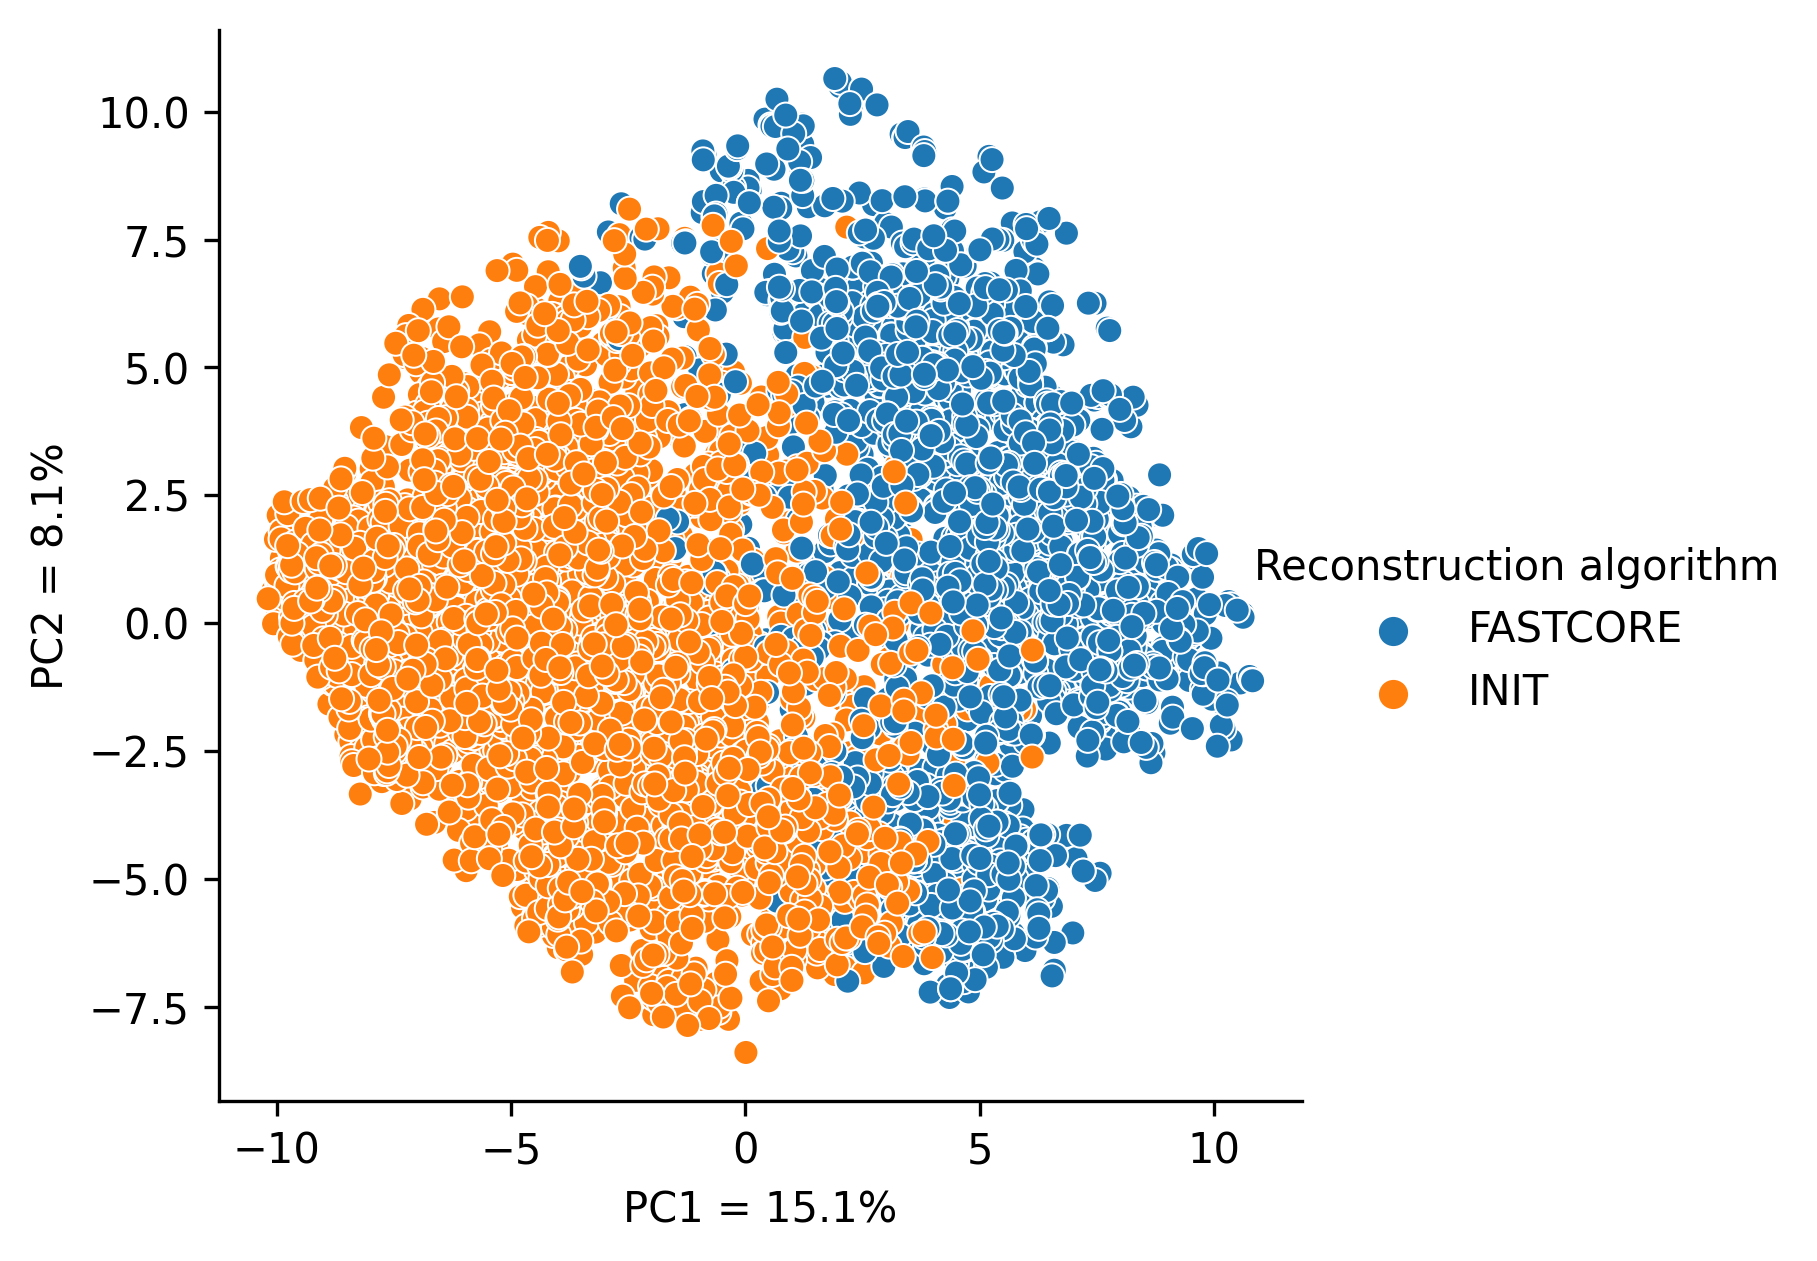

In [19]:
pca_mat_allmodels = run_pipeline(df=pfba_sims_irrev, y=model_metadata['disease'], 
                                 pipeline=pca_pipeline, append_metadata=model_metadata,
                                 var_thres__threshold=1e-4, sel_kbest__k = 200,
                                 sel_kbest__score_func=f_classif, pca__n_components = 10)


explained_variance = pca_pipeline.steps[-1][1].explained_variance_ratio_
explained_variance_str = list(map(lambda x: f"{x*100:.1f}%", explained_variance))

g = sns.relplot(data=pca_mat_allmodels.rename(columns=pretty_names).replace(pretty_names)
                ,x='PC1', y='PC2',hue=pretty_names['algorithm'])
g.set_xlabels(f'PC1 = {explained_variance_str[0]}')
g.set_ylabels(f'PC2 = {explained_variance_str[1]}')
g.fig.set_size_inches(6,4)
g.fig.set_dpi(300)

plt.savefig(NB_FOLDER+'/ccle_pfba_by_algorithm.pdf')

In [20]:
model_df_presence = model_df_post_gapfill.copy()
model_df_presence.columns = [c+'_presence' for c in model_df_presence.columns]
model_df_merged = pd.concat([model_df_presence, pfba_sims_df_scl], axis=1)

In [21]:
bc_subtype_names = {
    'HER2_amp': 'HER2+',
    'luminal': 'Luminal',
    'basal_A': 'Basal A',
    'basal_B': 'Basal B',
    'basal': 'Basal',
    'luminal_HER2_amp': 'Luminal HER2+'
}

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115 RuntimeWarning: divide by zero encountered in true_divide


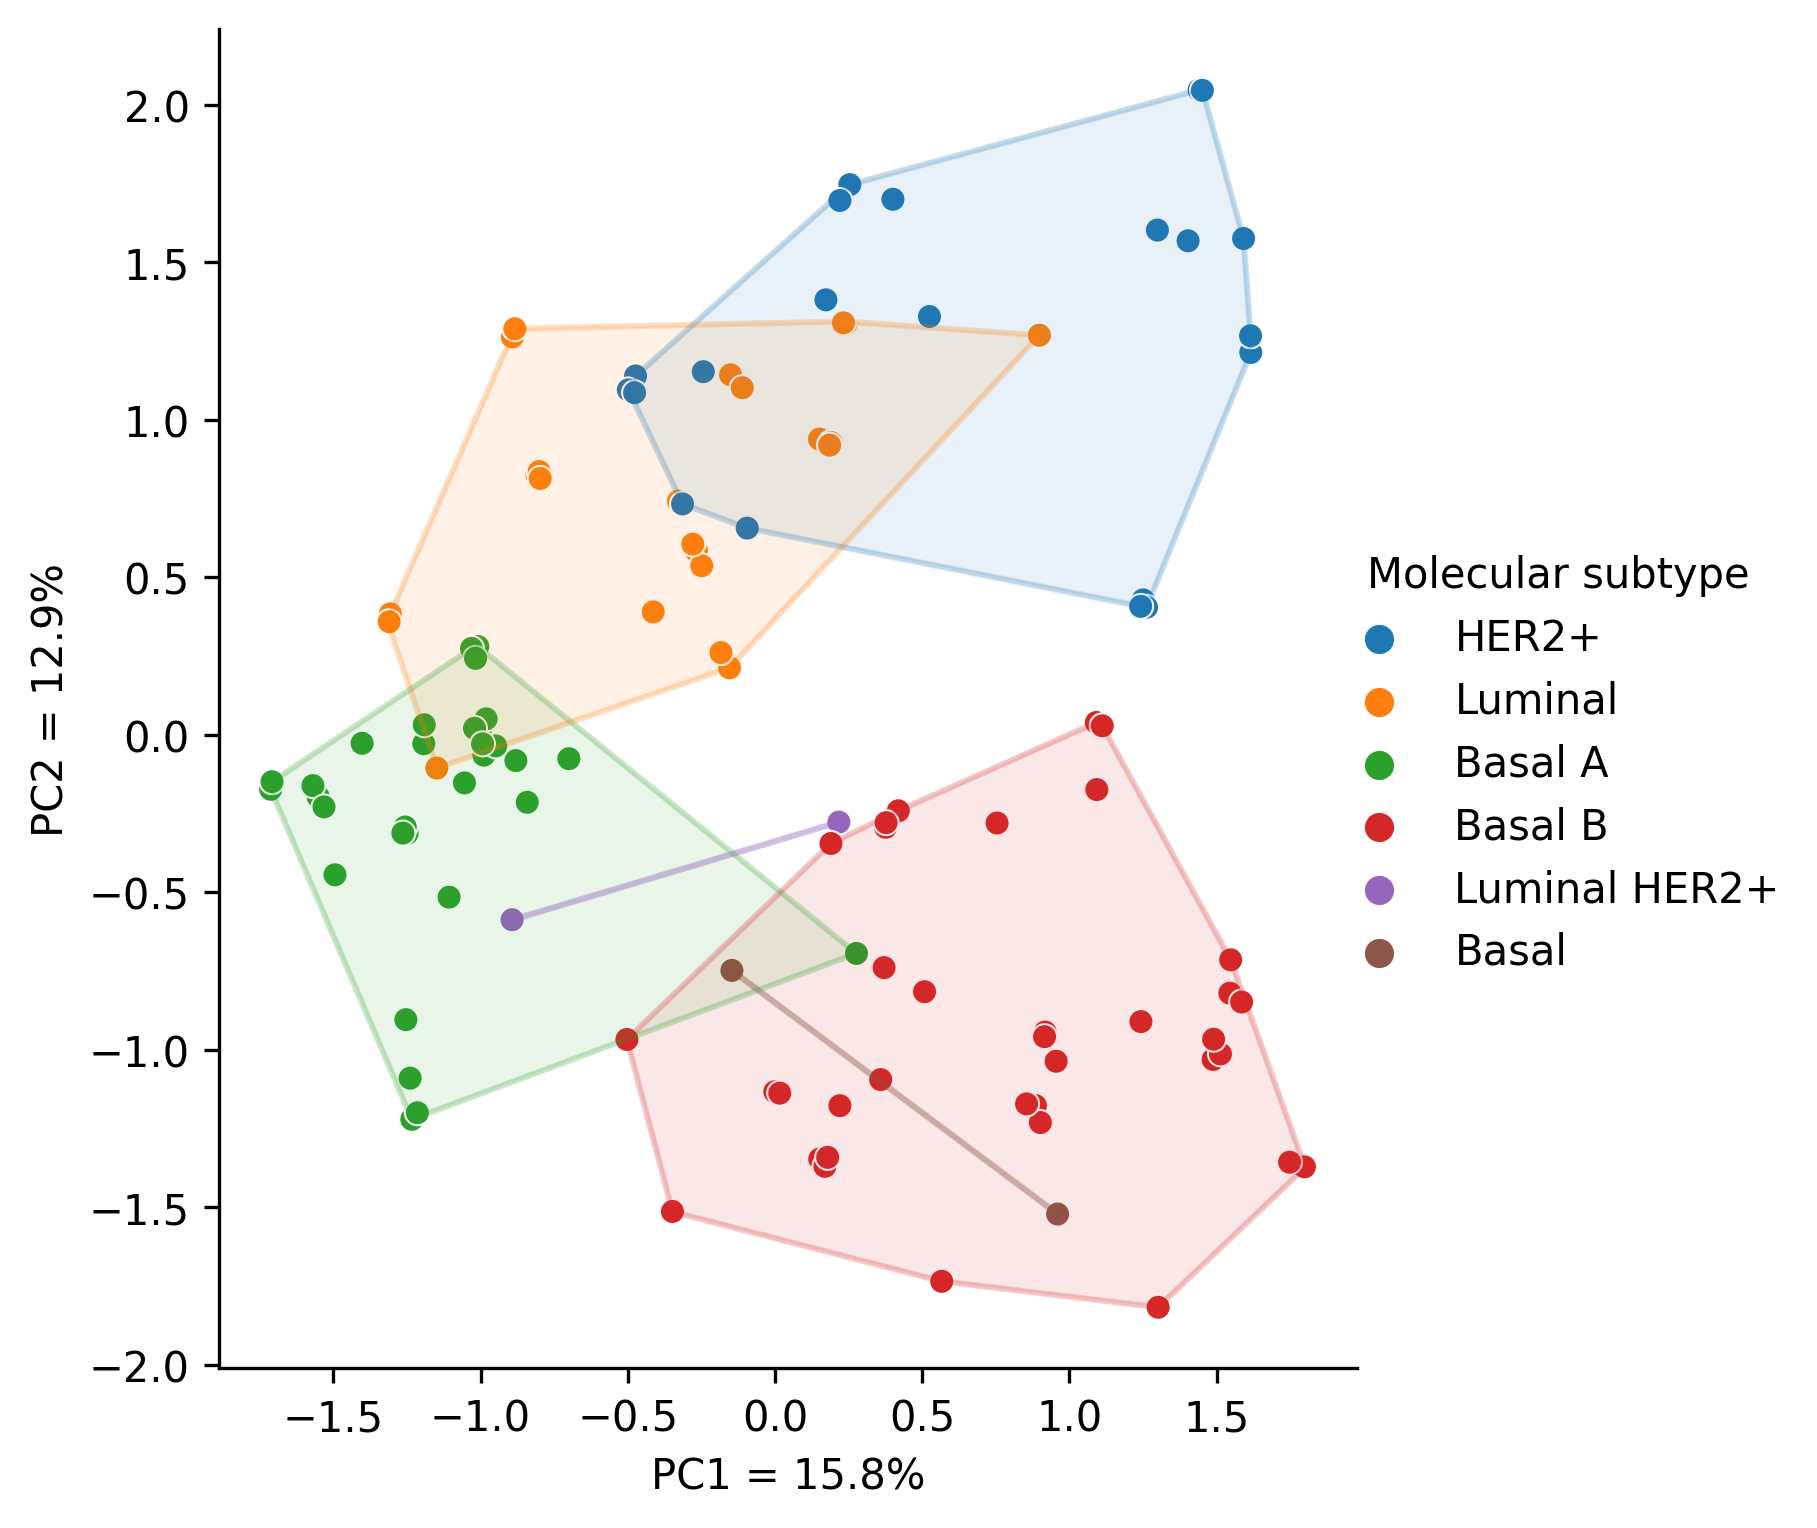

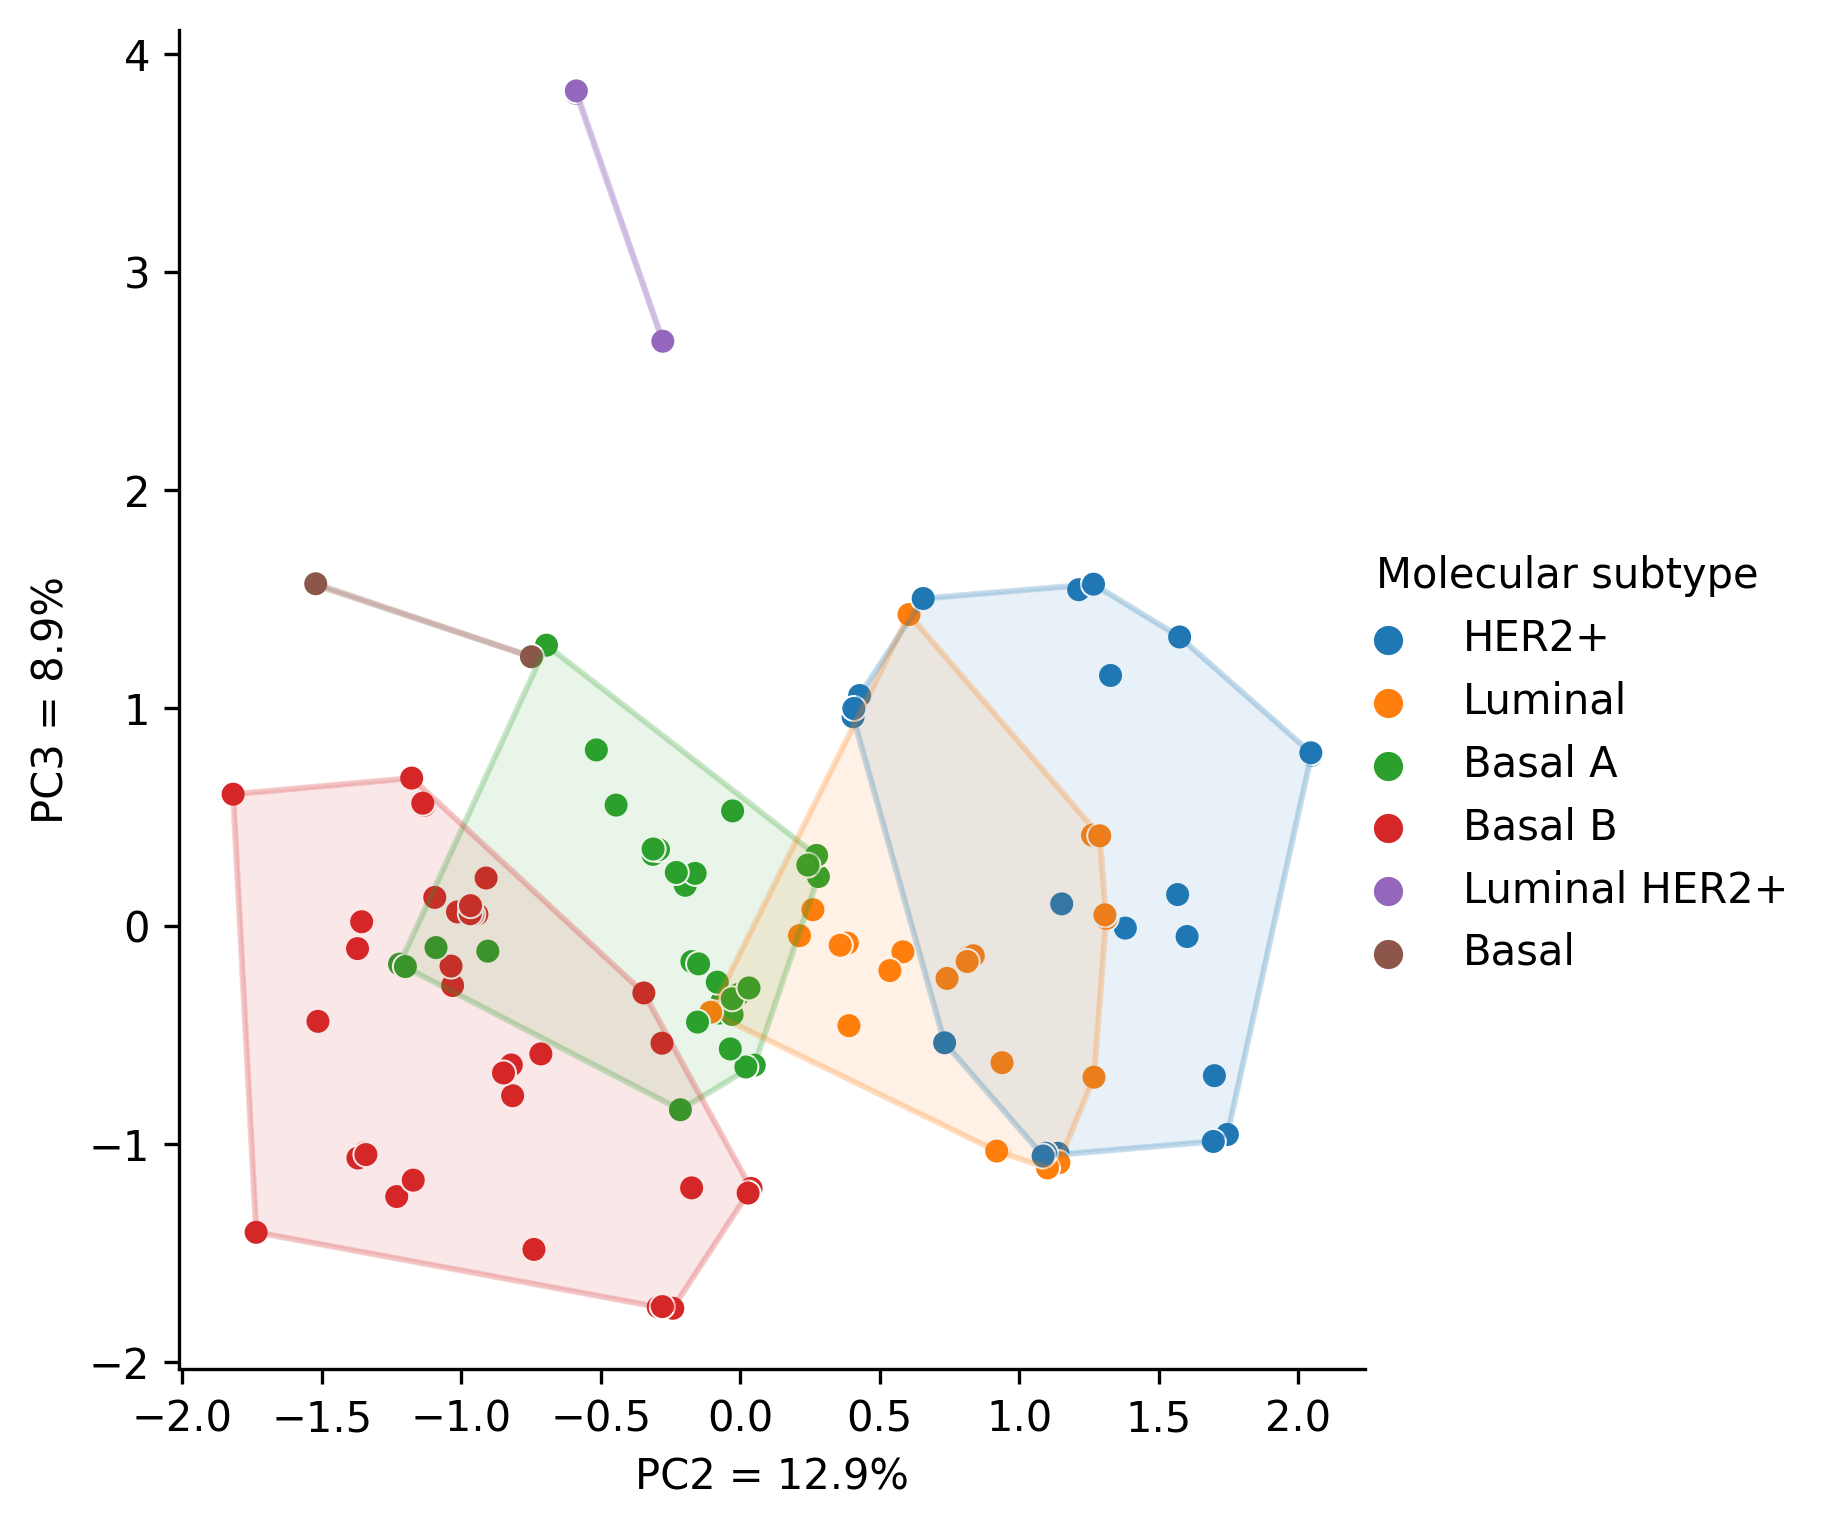

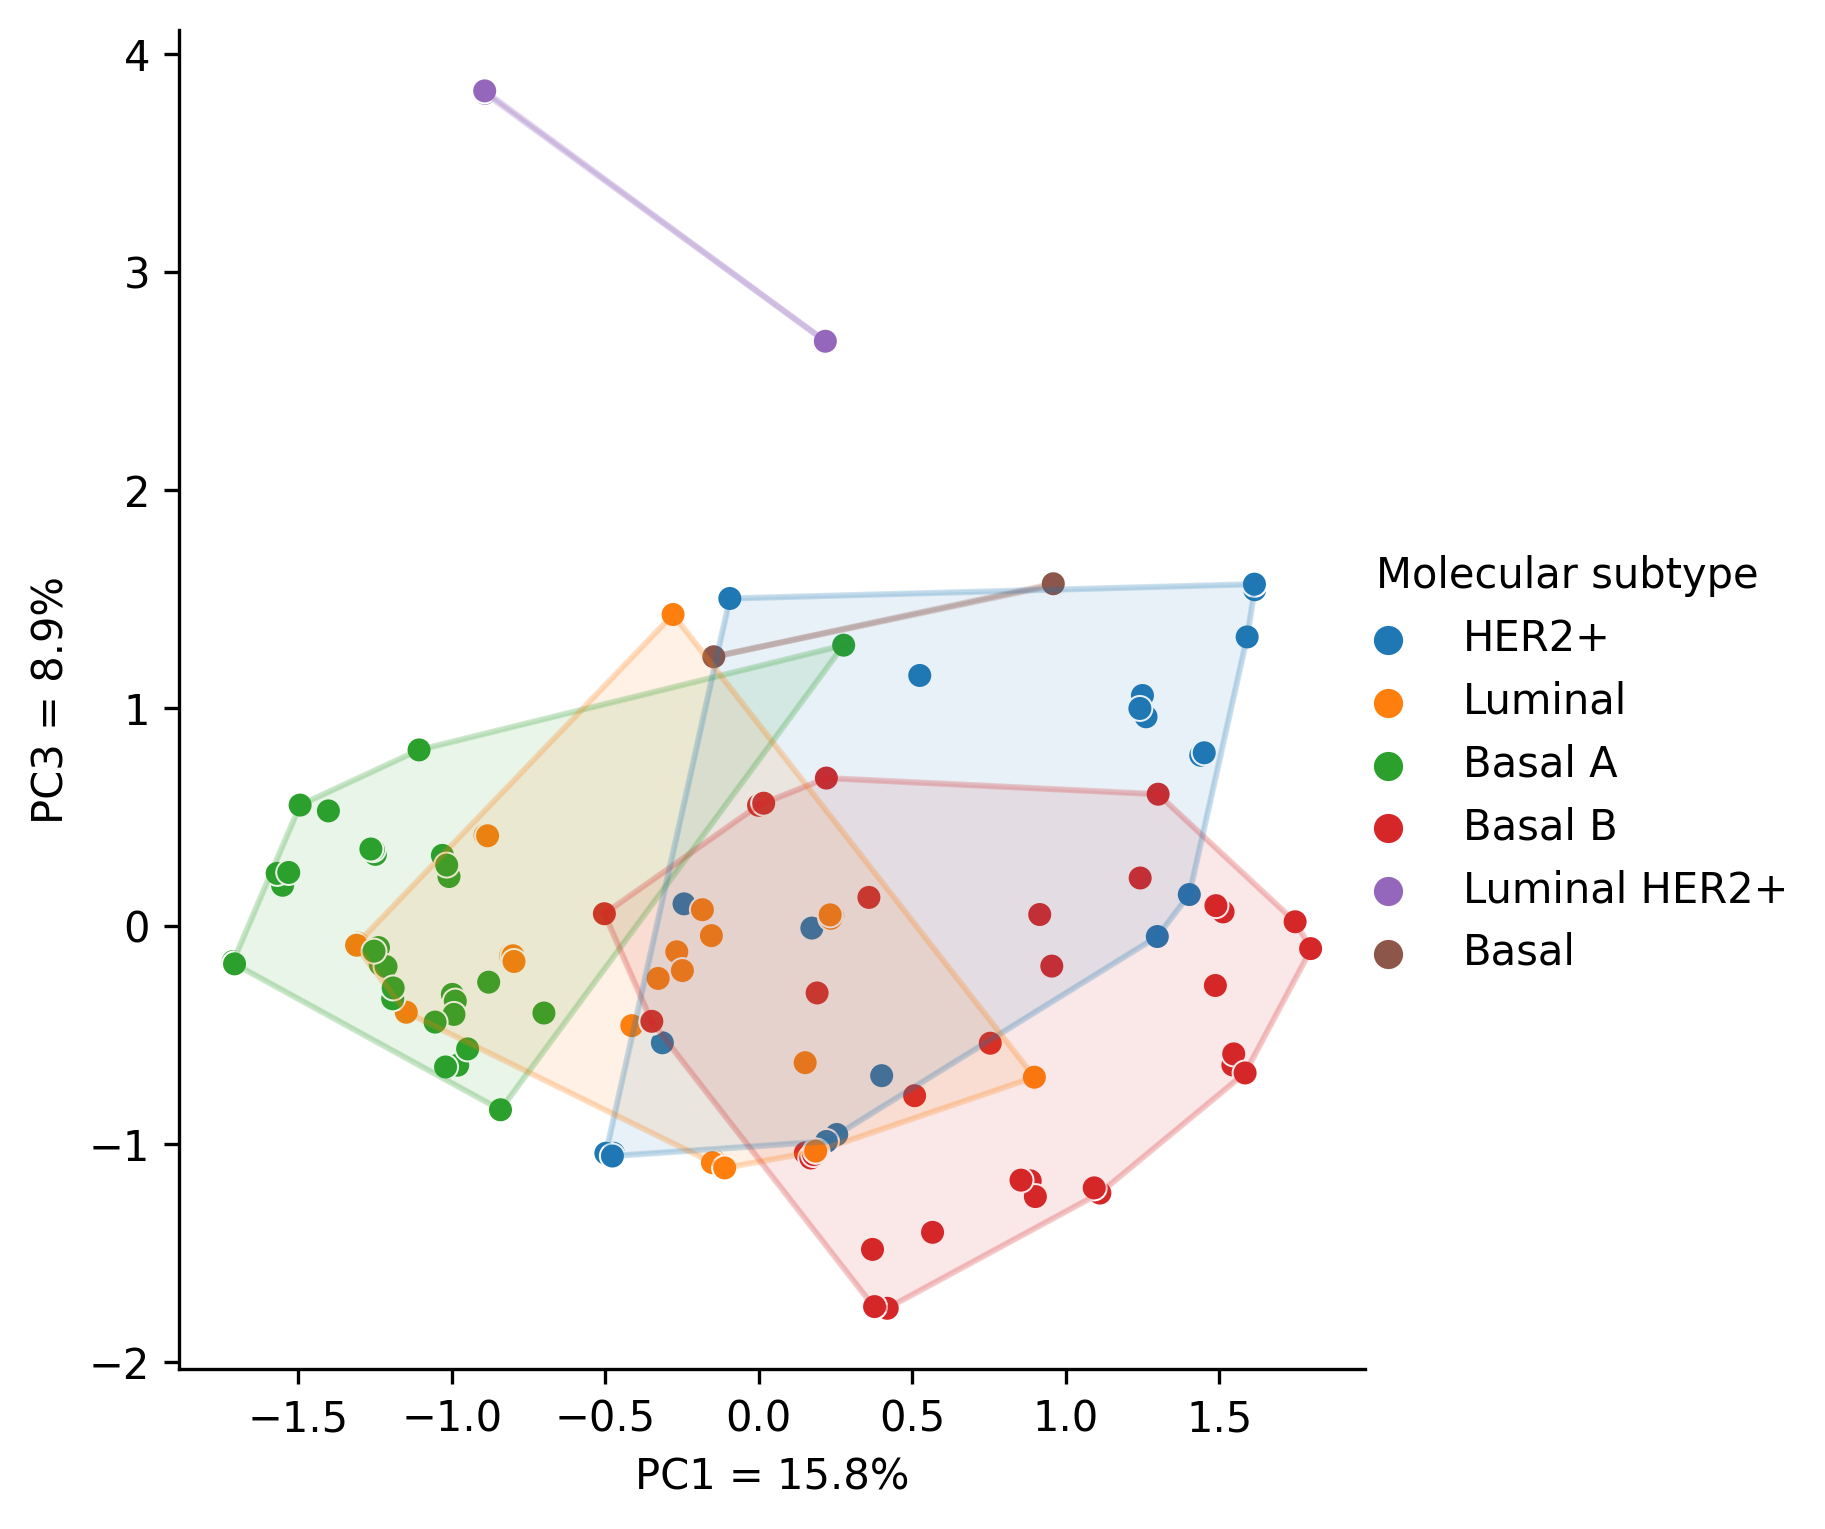

In [22]:
group_var = 'lineage_molecular_subtype'
group_var_name = 'Molecular subtype'
subset_md = model_metadata.query('algorithm == "fastcore" & disease == "Breast Cancer"')\
            .fillna('undefined').replace(bc_subtype_names).rename(columns={group_var: group_var_name})
subset = pfba_sims_irrev.loc[subset_md.index,:]

n_features = 250
pca_subset = run_pipeline(df=subset, y=subset_md[group_var_name], 
                         pipeline=pca_pipeline, append_metadata=subset_md,
                         var_thres__threshold=0, sel_kbest__k = n_features,
                         sel_kbest__score_func=f_classif, pca__n_components = min(subset.shape[0], n_features),
                         pca__whiten=True)

explained_variance_str = dict(zip(['PC'+str(i+1) for i in range(3)],list(map(lambda x: f"{x*100:.1f}%", 
                                  pca_pipeline.steps[-1][1].explained_variance_ratio_[:3]))))

for pc_combo in [['PC1','PC2'],['PC2','PC3'],['PC1','PC3']]:
    p1 = group_scatterplot(pca_subset, pc_combo, group_var_name, sns_plot_func=sns.relplot)
    p1.set_xlabels(f'{pc_combo[0]} = {explained_variance_str[pc_combo[0]]}')
    p1.set_ylabels(f'{pc_combo[1]} = {explained_variance_str[pc_combo[1]]}')
    p1.fig.set_size_inches(6, 5)
    p1.fig.set_dpi(300)
    plt.savefig(NB_FOLDER+'/ccle_breast_cancer_pca_'+'-'.join(pc_combo)+'.pdf')

In [23]:
exchanges = {r.id: list(r.metabolites)[0].name+' exchange' for r in cobra_model.boundary}
bigg_names = {r.id:r.annotation['bigg.reaction'] if 'bigg.reaction' in r.annotation.keys() else r.id 
              for r in cobra_model.reactions }
bigg_names.update(exchanges)

In [24]:
features = subset.columns[pca_pipeline.steps[-3][1].get_support()][pca_pipeline.steps[-2][1].get_support()]
features = [bigg_names[k.replace('_reverse_flux','')]+('_reverse_flux' if '_reverse_flux' in k else '') for k in features]
loadings = pd.DataFrame(pca_pipeline.steps[-1][1].components_.T, index=features)
pca_feature_mapping = {i: list(j) for i,j in {k:set(v) & set(loadings.index) 
                                        for k,v in pathway_mapping.items()}.items() if len(j) > 0}

pca_pathway_score = pd.DataFrame({pc:{path: (row[rxs].abs().mean()) for path,rxs in pca_feature_mapping.items()} 
              for pc, row in (loadings/loadings.abs().max(axis=0)).abs().T.iterrows()})
pca_pathway_score_norm = (pca_pathway_score - pca_pathway_score.mean())/pca_pathway_score.std()

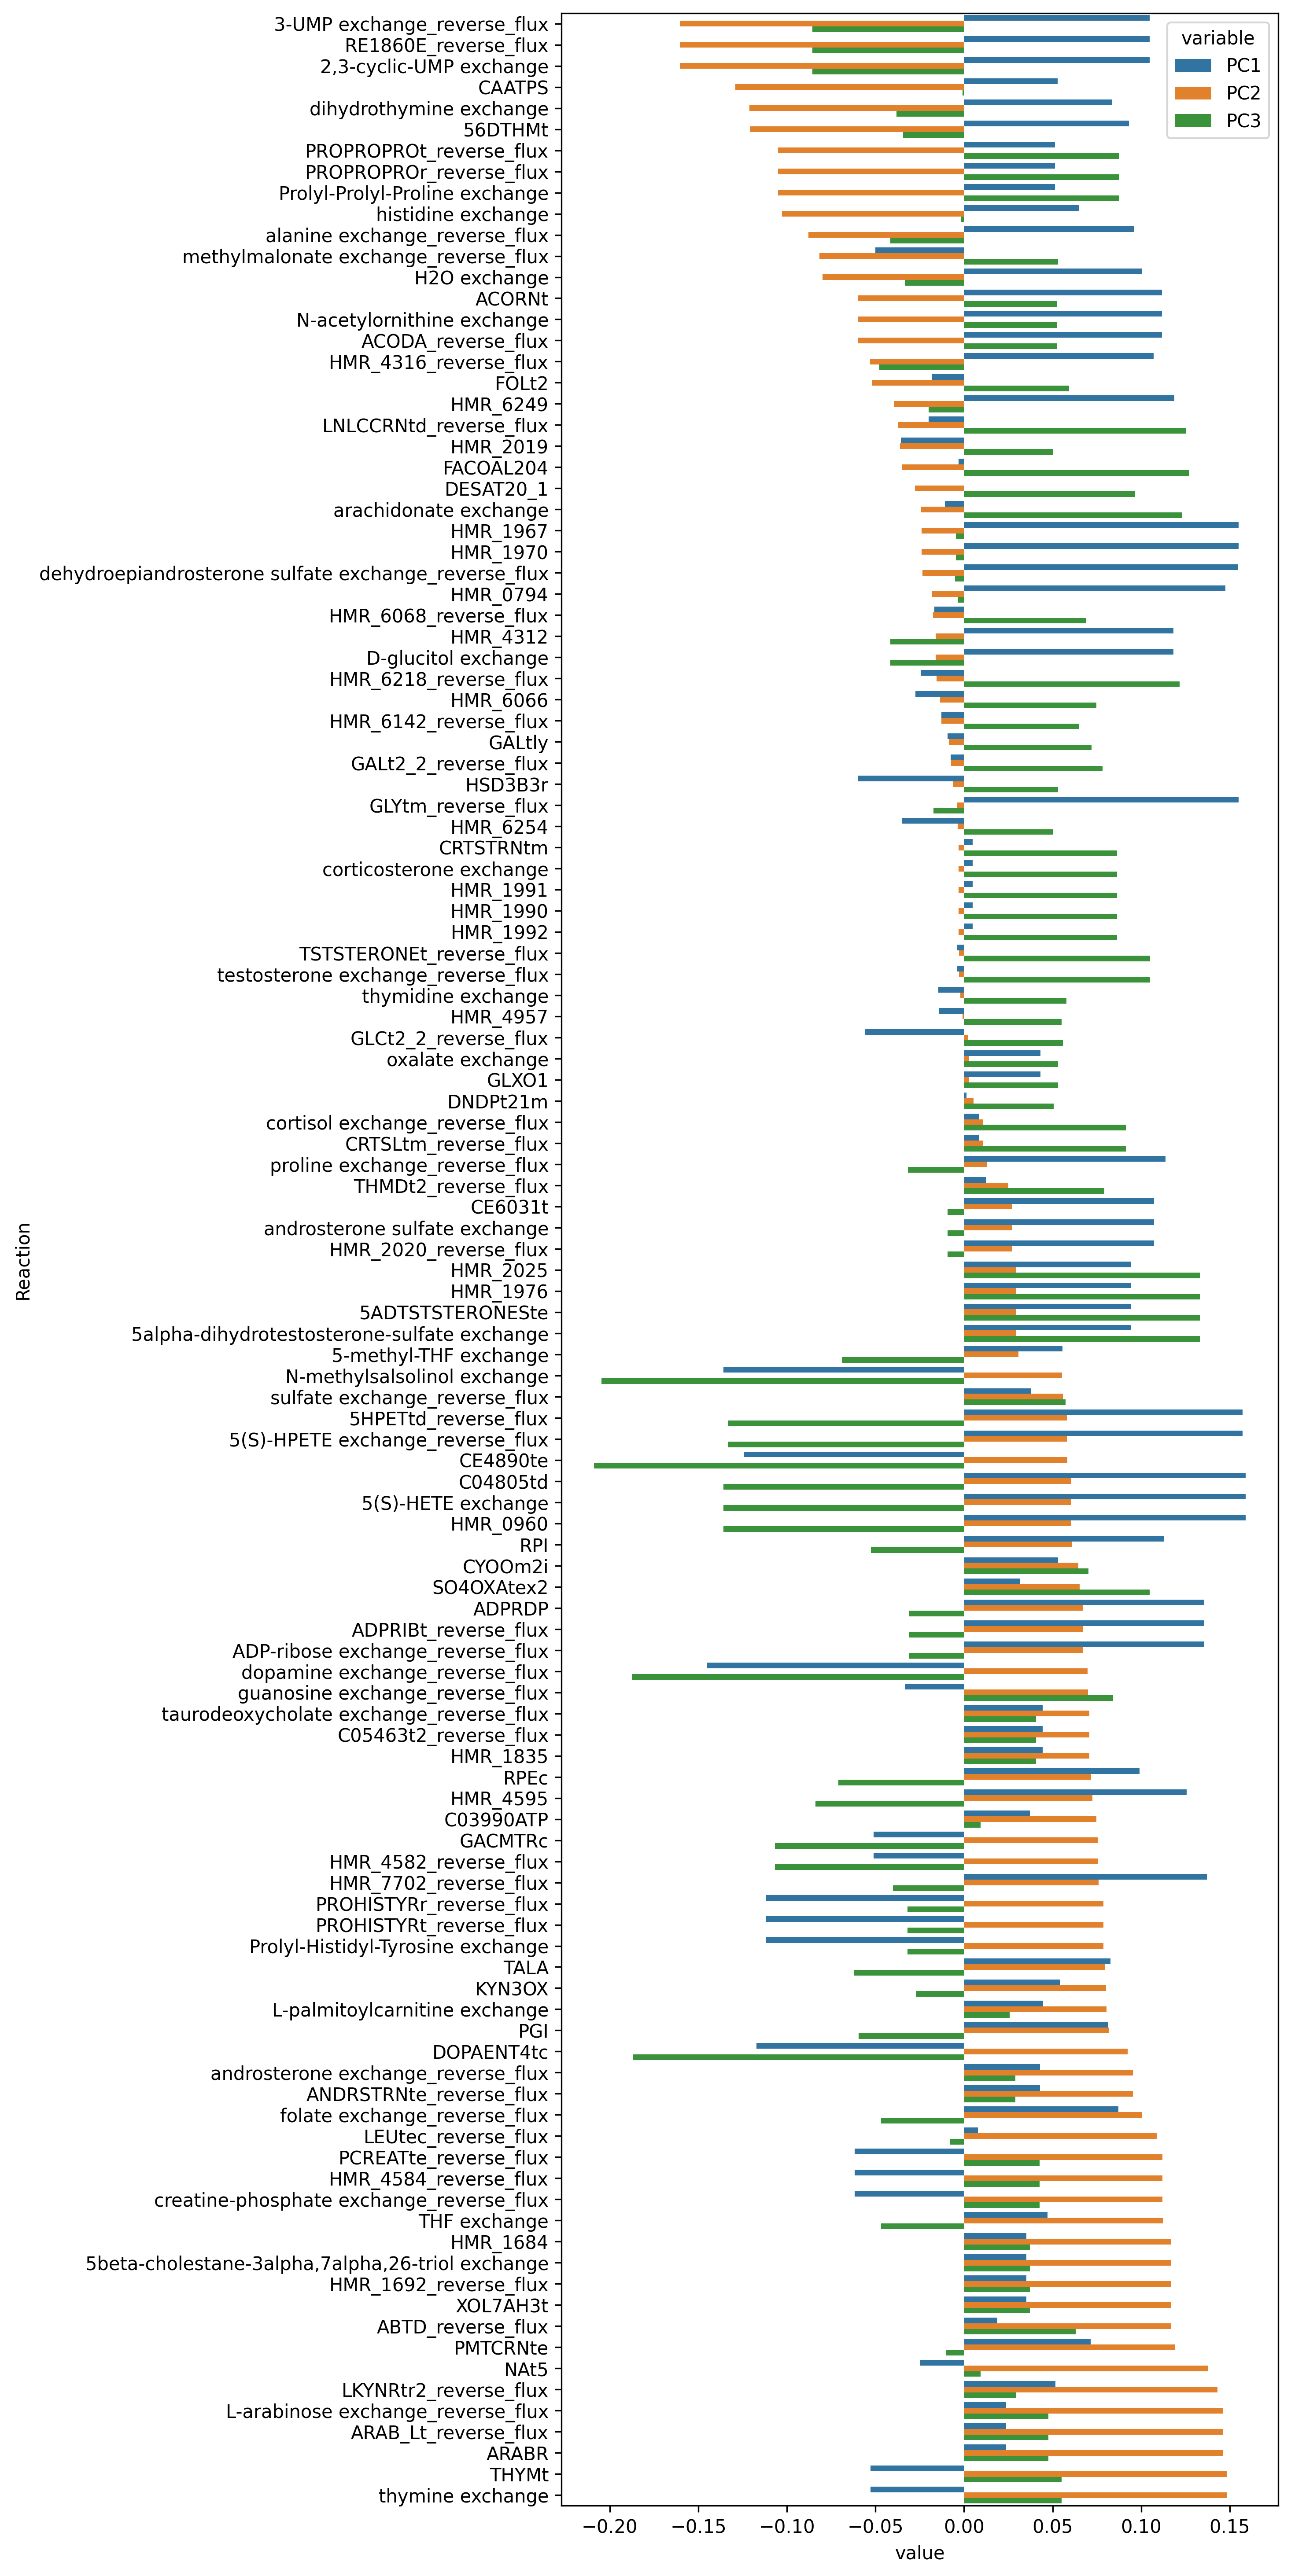

In [25]:
loading_heatmap_data = loadings.iloc[:,:3]
loading_heatmap_data = loading_heatmap_data[(loading_heatmap_data > 0.05).any(axis=1)]
maxv = loading_heatmap_data.abs().max().max()
loading_melt = loading_heatmap_data.reset_index()
loading_melt.columns = ['Reaction','PC1','PC2','PC3']
fig = plt.figure()
g = sns.barplot(data=pd.melt(loading_melt.sort_values(by='PC2'), id_vars='Reaction'), y='Reaction',x='value',hue='variable')
fig.set_size_inches(7, 25)
fig.set_dpi(300)

In [26]:
scores_df = pd.read_csv('projects/ccle_models/data/ccle/DepMap Public 20Q1/CCLE_expression_best_scores.csv', index_col=0)
scores_df.columns = [k.split('(')[1].replace(')','').strip() for k in scores_df.columns]
scores_md = sample_info.loc[[k.split('_')[0] for k in scores_df.index],:]
scores_md.index = scores_df.index

scores_df_orig = pd.read_csv('projects/breast_mcf7/data/ccle/DepMap Public 20Q1/CCLE_expression_full.csv', index_col=0)
scores_df_orig.columns = [k.split('(')[1].replace(')','').strip() for k in scores_df_orig.columns]
scores_df_orig = scores_df_orig[scores_df.columns]
scores_df_orig_match = scores_df_orig.loc[list(set([k.split('_')[0] for k in scores_df.index])),:]
scores_df_orig_match
scores_md_orig = sample_info.loc[scores_df_orig_match.index,:]

In [32]:
scores_df_norm = ((scores_df_orig_match - scores_df_orig_match.mean())/scores_df_orig_match.std()).fillna(0)

In [29]:
metabolic_model_genes = [g.id for g in cobra_model.genes]

In [34]:
datasets = {
    'scaled_data': [scores_df_norm, scores_md_orig],
    'scaled_metabolic_data': [scores_df_norm[metabolic_model_genes], scores_md_orig],
    'gene_scores': [scores_df, scores_md],
    'model_simulations': [pfba_sims_irrev, model_metadata.query('algorithm == "fastcore"')],
    'reaction_presence': [model_df_post_gapfill, model_metadata]
}

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score

extra = {'average':'weighted'}

def calc_metric(func, params): 
    return lambda y_true, y_pred: func(y_true, y_pred, **params)

def score_model(ppl, X, y, cv, metric_funcs, n_jobs):
    cv_res = cross_validate(ppl, X, y, cv=cv, n_jobs=n_jobs,
                            scoring=metric_funcs, return_estimator=True)
    cv_res_no_est = {k:v for k,v in cv_res.items() if k != 'estimator'}
    return pd.DataFrame(cv_res), cv_res['estimator']

def get_xy_mat(dfs):
    mat, metadata = dfs
    orig_X = mat.loc[~mat.isna().any(axis=1),:]

    X = orig_X.loc[metadata.index,:]
    y = metadata['disease']
    return X, y

In [36]:
metrics = {
    'f1': 'f1_weighted',
    'precision_score': 'precision_weighted',
    'recall_score': 'recall_weighted',
    'mcc': matthews_corrcoef}

metric_funcs = {k: calc_metric(v, extra if k != 'mcc' else {}) for k,v in metrics.items()}

In [37]:
kb_options = [200, 2000]

pipelines = {}
for k in kb_options:
    for data_name, dfs in datasets.items():
        ppl = Pipeline([
            ('vt', VarianceThreshold(1e-5)),
            ('fs', SelectKBest(score_func=f_classif, k=k)),
        ])
        X, y = get_xy_mat(dfs)
        ppl.fit_transform(X, y)
        pipelines[(data_name,k)] = ppl

In [38]:
from numpy import array_split, isin, where
from numpy.random import shuffle

In [39]:
def fold_generator(column_to_group, k):
    unq = column_to_group.unique()
    shuffle(unq)
    return array_split(unq, k)

def fold_iter(column_to_group, folds):
    for fold in folds:
        mask = isin(column_to_group, fold)
        yield list(map(lambda x: where(x)[0].tolist(), [~mask, mask]))

In [40]:
cv_options = [5, 10]
runs = 10
results = {}
cv_fold_dict = {}
cv_post_res = {}
scorers = {k:make_scorer(v) if not isinstance(v, str) else v for k,v in metrics.items()}

for run in range(runs):
    print('Run',run+1)
    for cvk in cv_options:
        cv_folds = fold_generator(model_metadata.CCLE_Name, cvk)
        cv_fold_dict[(cvk,run)] = cv_folds
        for data_name, dfs in datasets.items():
            nX, y = get_xy_mat(dfs)
            for kb in kb_options:
                curppl = pipelines[(data_name, kb)]
                X = pd.DataFrame(curppl.transform(nX), index = nX.index)
                for rfn in [10, 100]:
                    clf = RandomForestClassifier(n_estimators=rfn, n_jobs=1)
                    key = (data_name,kb,cvk,run,rfn)
                    if key not in results.keys():
                        print('\t'+str(key))
                        cv_iter = fold_iter(dfs[1].CCLE_Name, cv_folds)
                        res = score_model(clf, X, y, cv_iter, scorers, n_jobs=cvk)                     
                        cvfn = fold_iter(dfs[1].CCLE_Name, cv_folds)
                        cv_post_res[key] = []
                        for fold_estimator, cvfolds in zip(res[1],cvfn):
                            sub_index = X.iloc[cvfolds[1],:].index
                            submat, suby = X.iloc[cvfolds[1],:], y.iloc[cvfolds[1]]
                            cv_post_res[key].append({'predicted': fold_estimator.predict(submat), 
                                                   'real': suby.values, 'data_index': sub_index})
                            
                        results[key] = {k:v for k,v in res[0].items() if k != 'estimator'}


Run 1
	('scaled_data', 200, 5, 0, 10)
	('scaled_data', 200, 5, 0, 100)
	('scaled_data', 2000, 5, 0, 10)
	('scaled_data', 2000, 5, 0, 100)
	('scaled_metabolic_data', 200, 5, 0, 10)
	('scaled_metabolic_data', 200, 5, 0, 100)
	('scaled_metabolic_data', 2000, 5, 0, 10)
	('scaled_metabolic_data', 2000, 5, 0, 100)
	('gene_scores', 200, 5, 0, 10)
	('gene_scores', 200, 5, 0, 100)
	('gene_scores', 2000, 5, 0, 10)
	('gene_scores', 2000, 5, 0, 100)
	('model_simulations', 200, 5, 0, 10)
	('model_simulations', 200, 5, 0, 100)
	('model_simulations', 2000, 5, 0, 10)
	('model_simulations', 2000, 5, 0, 100)
	('reaction_presence', 200, 5, 0, 10)
	('reaction_presence', 200, 5, 0, 100)
	('reaction_presence', 2000, 5, 0, 10)
	('reaction_presence', 2000, 5, 0, 100)
	('scaled_data', 200, 10, 0, 10)
	('scaled_data', 200, 10, 0, 100)
	('scaled_data', 2000, 10, 0, 10)
	('scaled_data', 2000, 10, 0, 100)
	('scaled_metabolic_data', 200, 10, 0, 10)
	('scaled_metabolic_data', 200, 10, 0, 100)
	('scaled_metabolic_dat

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('reaction_presence', 2000, 10, 0, 100)
Run 2
	('scaled_data', 200, 5, 1, 10)
	('scaled_data', 200, 5, 1, 100)
	('scaled_data', 2000, 5, 1, 10)
	('scaled_data', 2000, 5, 1, 100)
	('scaled_metabolic_data', 200, 5, 1, 10)
	('scaled_metabolic_data', 200, 5, 1, 100)
	('scaled_metabolic_data', 2000, 5, 1, 10)
	('scaled_metabolic_data', 2000, 5, 1, 100)
	('gene_scores', 200, 5, 1, 10)
	('gene_scores', 200, 5, 1, 100)
	('gene_scores', 2000, 5, 1, 10)
	('gene_scores', 2000, 5, 1, 100)
	('model_simulations', 200, 5, 1, 10)
	('model_simulations', 200, 5, 1, 100)
	('model_simulations', 2000, 5, 1, 10)


/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('model_simulations', 2000, 5, 1, 100)
	('reaction_presence', 200, 5, 1, 10)
	('reaction_presence', 200, 5, 1, 100)
	('reaction_presence', 2000, 5, 1, 10)
	('reaction_presence', 2000, 5, 1, 100)
	('scaled_data', 200, 10, 1, 10)
	('scaled_data', 200, 10, 1, 100)
	('scaled_data', 2000, 10, 1, 10)
	('scaled_data', 2000, 10, 1, 100)
	('scaled_metabolic_data', 200, 10, 1, 10)
	('scaled_metabolic_data', 200, 10, 1, 100)
	('scaled_metabolic_data', 2000, 10, 1, 10)
	('scaled_metabolic_data', 2000, 10, 1, 100)
	('gene_scores', 200, 10, 1, 10)
	('gene_scores', 200, 10, 1, 100)
	('gene_scores', 2000, 10, 1, 10)
	('gene_scores', 2000, 10, 1, 100)
	('model_simulations', 200, 10, 1, 10)
	('model_simulations', 200, 10, 1, 100)
	('model_simulations', 2000, 10, 1, 10)
	('model_simulations', 2000, 10, 1, 100)
	('reaction_presence', 200, 10, 1, 10)
	('reaction_presence', 200, 10, 1, 100)
	('reaction_presence', 2000, 10, 1, 10)
	('reaction_presence', 2000, 10, 1, 100)
Run 3
	('scaled_data', 200, 5, 2, 10

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('model_simulations', 2000, 5, 2, 100)
	('reaction_presence', 200, 5, 2, 10)
	('reaction_presence', 200, 5, 2, 100)
	('reaction_presence', 2000, 5, 2, 10)
	('reaction_presence', 2000, 5, 2, 100)
	('scaled_data', 200, 10, 2, 10)
	('scaled_data', 200, 10, 2, 100)
	('scaled_data', 2000, 10, 2, 10)
	('scaled_data', 2000, 10, 2, 100)
	('scaled_metabolic_data', 200, 10, 2, 10)
	('scaled_metabolic_data', 200, 10, 2, 100)
	('scaled_metabolic_data', 2000, 10, 2, 10)
	('scaled_metabolic_data', 2000, 10, 2, 100)
	('gene_scores', 200, 10, 2, 10)
	('gene_scores', 200, 10, 2, 100)
	('gene_scores', 2000, 10, 2, 10)
	('gene_scores', 2000, 10, 2, 100)
	('model_simulations', 200, 10, 2, 10)
	('model_simulations', 200, 10, 2, 100)
	('model_simulations', 2000, 10, 2, 10)
	('model_simulations', 2000, 10, 2, 100)
	('reaction_presence', 200, 10, 2, 10)
	('reaction_presence', 200, 10, 2, 100)
	('reaction_presence', 2000, 10, 2, 10)
	('reaction_presence', 2000, 10, 2, 100)
Run 4
	('scaled_data', 200, 5, 3, 10

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('model_simulations', 2000, 5, 4, 100)
	('reaction_presence', 200, 5, 4, 10)
	('reaction_presence', 200, 5, 4, 100)
	('reaction_presence', 2000, 5, 4, 10)
	('reaction_presence', 2000, 5, 4, 100)
	('scaled_data', 200, 10, 4, 10)
	('scaled_data', 200, 10, 4, 100)
	('scaled_data', 2000, 10, 4, 10)
	('scaled_data', 2000, 10, 4, 100)
	('scaled_metabolic_data', 200, 10, 4, 10)
	('scaled_metabolic_data', 200, 10, 4, 100)
	('scaled_metabolic_data', 2000, 10, 4, 10)
	('scaled_metabolic_data', 2000, 10, 4, 100)
	('gene_scores', 200, 10, 4, 10)
	('gene_scores', 200, 10, 4, 100)
	('gene_scores', 2000, 10, 4, 10)
	('gene_scores', 2000, 10, 4, 100)
	('model_simulations', 200, 10, 4, 10)
	('model_simulations', 200, 10, 4, 100)
	('model_simulations', 2000, 10, 4, 10)
	('model_simulations', 2000, 10, 4, 100)
	('reaction_presence', 200, 10, 4, 10)
	('reaction_presence', 200, 10, 4, 100)
	('reaction_presence', 2000, 10, 4, 10)
	('reaction_presence', 2000, 10, 4, 100)
Run 6
	('scaled_data', 200, 5, 5, 10

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('model_simulations', 2000, 5, 5, 100)
	('reaction_presence', 200, 5, 5, 10)
	('reaction_presence', 200, 5, 5, 100)
	('reaction_presence', 2000, 5, 5, 10)
	('reaction_presence', 2000, 5, 5, 100)
	('scaled_data', 200, 10, 5, 10)
	('scaled_data', 200, 10, 5, 100)
	('scaled_data', 2000, 10, 5, 10)
	('scaled_data', 2000, 10, 5, 100)
	('scaled_metabolic_data', 200, 10, 5, 10)
	('scaled_metabolic_data', 200, 10, 5, 100)
	('scaled_metabolic_data', 2000, 10, 5, 10)
	('scaled_metabolic_data', 2000, 10, 5, 100)
	('gene_scores', 200, 10, 5, 10)
	('gene_scores', 200, 10, 5, 100)
	('gene_scores', 2000, 10, 5, 10)
	('gene_scores', 2000, 10, 5, 100)
	('model_simulations', 200, 10, 5, 10)
	('model_simulations', 200, 10, 5, 100)
	('model_simulations', 2000, 10, 5, 10)
	('model_simulations', 2000, 10, 5, 100)
	('reaction_presence', 200, 10, 5, 10)
	('reaction_presence', 200, 10, 5, 100)
	('reaction_presence', 2000, 10, 5, 10)
	('reaction_presence', 2000, 10, 5, 100)
Run 7
	('scaled_data', 200, 5, 6, 10

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('model_simulations', 2000, 5, 6, 100)
	('reaction_presence', 200, 5, 6, 10)
	('reaction_presence', 200, 5, 6, 100)
	('reaction_presence', 2000, 5, 6, 10)
	('reaction_presence', 2000, 5, 6, 100)
	('scaled_data', 200, 10, 6, 10)
	('scaled_data', 200, 10, 6, 100)
	('scaled_data', 2000, 10, 6, 10)
	('scaled_data', 2000, 10, 6, 100)
	('scaled_metabolic_data', 200, 10, 6, 10)
	('scaled_metabolic_data', 200, 10, 6, 100)
	('scaled_metabolic_data', 2000, 10, 6, 10)
	('scaled_metabolic_data', 2000, 10, 6, 100)
	('gene_scores', 200, 10, 6, 10)
	('gene_scores', 200, 10, 6, 100)
	('gene_scores', 2000, 10, 6, 10)
	('gene_scores', 2000, 10, 6, 100)
	('model_simulations', 200, 10, 6, 10)
	('model_simulations', 200, 10, 6, 100)
	('model_simulations', 2000, 10, 6, 10)
	('model_simulations', 2000, 10, 6, 100)
	('reaction_presence', 200, 10, 6, 10)
	('reaction_presence', 200, 10, 6, 100)
	('reaction_presence', 2000, 10, 6, 10)
	('reaction_presence', 2000, 10, 6, 100)
Run 8
	('scaled_data', 200, 5, 7, 10

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('model_simulations', 2000, 5, 7, 100)
	('reaction_presence', 200, 5, 7, 10)
	('reaction_presence', 200, 5, 7, 100)
	('reaction_presence', 2000, 5, 7, 10)
	('reaction_presence', 2000, 5, 7, 100)
	('scaled_data', 200, 10, 7, 10)
	('scaled_data', 200, 10, 7, 100)
	('scaled_data', 2000, 10, 7, 10)
	('scaled_data', 2000, 10, 7, 100)
	('scaled_metabolic_data', 200, 10, 7, 10)
	('scaled_metabolic_data', 200, 10, 7, 100)
	('scaled_metabolic_data', 2000, 10, 7, 10)
	('scaled_metabolic_data', 2000, 10, 7, 100)
	('gene_scores', 200, 10, 7, 10)
	('gene_scores', 200, 10, 7, 100)
	('gene_scores', 2000, 10, 7, 10)
	('gene_scores', 2000, 10, 7, 100)
	('model_simulations', 200, 10, 7, 10)
	('model_simulations', 200, 10, 7, 100)
	('model_simulations', 2000, 10, 7, 10)
	('model_simulations', 2000, 10, 7, 100)
	('reaction_presence', 200, 10, 7, 10)
	('reaction_presence', 200, 10, 7, 100)
	('reaction_presence', 2000, 10, 7, 10)
	('reaction_presence', 2000, 10, 7, 100)
Run 9
	('scaled_data', 200, 5, 8, 10

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706 UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


	('model_simulations', 2000, 5, 8, 100)
	('reaction_presence', 200, 5, 8, 10)
	('reaction_presence', 200, 5, 8, 100)
	('reaction_presence', 2000, 5, 8, 10)
	('reaction_presence', 2000, 5, 8, 100)
	('scaled_data', 200, 10, 8, 10)
	('scaled_data', 200, 10, 8, 100)
	('scaled_data', 2000, 10, 8, 10)
	('scaled_data', 2000, 10, 8, 100)
	('scaled_metabolic_data', 200, 10, 8, 10)
	('scaled_metabolic_data', 200, 10, 8, 100)
	('scaled_metabolic_data', 2000, 10, 8, 10)
	('scaled_metabolic_data', 2000, 10, 8, 100)
	('gene_scores', 200, 10, 8, 10)
	('gene_scores', 200, 10, 8, 100)
	('gene_scores', 2000, 10, 8, 10)
	('gene_scores', 2000, 10, 8, 100)
	('model_simulations', 200, 10, 8, 10)
	('model_simulations', 200, 10, 8, 100)
	('model_simulations', 2000, 10, 8, 10)
	('model_simulations', 2000, 10, 8, 100)
	('reaction_presence', 200, 10, 8, 10)
	('reaction_presence', 200, 10, 8, 100)
	('reaction_presence', 2000, 10, 8, 10)
	('reaction_presence', 2000, 10, 8, 100)
Run 10
	('scaled_data', 200, 5, 9, 1

In [41]:
from collections import Counter

In [42]:
mcc_guess_dict = {}
for cvpk, cvpv in cv_post_res.items():
    df_single_model = pd.DataFrame(cv_post_res[cvpk])
    fcvdf = pd.concat(pd.DataFrame({k:list(v) for k,v in row.to_dict().items()}).assign(fold=i) 
                      for i, row in df_single_model.iterrows())

    fcvdf['cell_line'] = datasets[cvpk[0]][1].reindex(fcvdf.data_index)['CCLE_Name'].tolist()
    
    gdf_gen = fcvdf.groupby(['fold'])
    mcc_guess_dict[cvpk] = []
    for gi, gdf_gen_it in gdf_gen:
        pred_fcvdf = {i:Counter(row['predicted'].to_list()).most_common(1)[0][0] for i,row in gdf_gen_it.groupby('cell_line')}
        real_fcvdf = {i:Counter(row['real'].to_list()).most_common(1)[0][0] for i,row in gdf_gen_it.groupby('cell_line')}
        try:
            ord_cls = pred_fcvdf.keys()
            mcc_guess_dict[cvpk].append(matthews_corrcoef([real_fcvdf[k] for k in ord_cls],[pred_fcvdf[k] for k in ord_cls]))
        except Exception as e:
            print(cvpk,e)
    mcc_guess_dict[cvpk] = pd.Series(mcc_guess_dict[cvpk])

In [43]:
from sklearn.metrics import matthews_corrcoef

In [44]:
mcc_guess = pd.concat(mcc_guess_dict).reset_index().set_index('level_5')
mcc_guess.columns = ['dataset','features','cvk','run','n_estimators','mcc_guess']

In [45]:
ft_names = ['dataset','features','cvk','run','n_estimators']
model_stats_raw = pd.concat([pd.DataFrame(v).assign(**dict(zip(ft_names, k))) for k,v in results.items()])

In [46]:
ind_cols = ft_names + ['fold']

msr_index = model_stats_raw.reset_index().rename(columns = {'index':'fold'}).set_index(ind_cols)

In [47]:
msr_guess_index = mcc_guess.reset_index().rename(columns={'level_5': 'fold'}).set_index(ind_cols)

In [48]:
model_stats_raw = msr_index.join(msr_guess_index).reset_index()

In [49]:
model_stats = model_stats_raw.groupby('dataset').describe().T

model_stats_raw_melt = pd.melt(model_stats_raw.drop(columns=['fit_time','score_time']), id_vars=ind_cols)

In [65]:
model_stats_raw_melt

dataset  features  cvk  run  n_estimators  fold   variable  \
0            scaled_data       200    5    0            10     0    test_f1   
1            scaled_data       200    5    0            10     1    test_f1   
2            scaled_data       200    5    0            10     2    test_f1   
3            scaled_data       200    5    0            10     3    test_f1   
4            scaled_data       200    5    0            10     4    test_f1   
...                  ...       ...  ...  ...           ...   ...        ...   
14995  reaction_presence      2000   10    9           100     5  mcc_guess   
14996  reaction_presence      2000   10    9           100     6  mcc_guess   
14997  reaction_presence      2000   10    9           100     7  mcc_guess   
14998  reaction_presence      2000   10    9           100     8  mcc_guess   
14999  reaction_presence      2000   10    9           100     9  mcc_guess   

          value  
0      0.407107  
1      0.501903  
2      0.448043  
3      0.491925  
4      0.475053  
...         ...  
14995  0.473417  
14996  0.624832  
14997  0.596193  
14998  0.538387  
14999  0.653758  

[15000 rows x 8 columns]

In [71]:
model_stats_raw_melt = pd.melt(model_stats_raw.groupby(['dataset','run','features','cvk','n_estimators']).mean().\
drop(columns=['fold','fit_time','score_time']).reset_index(), id_vars=ind_cols[:-1])

In [72]:
model_stats_raw_melt.query('cvk == 5 & variable == "test_mcc"').\
groupby(['dataset','features','cvk','n_estimators']).mean()

run     value
dataset               features cvk n_estimators               
gene_scores           200      5   10            4.5  0.486164
                                   100           4.5  0.585328
                      2000     5   10            4.5  0.473909
                                   100           4.5  0.600313
model_simulations     200      5   10            4.5  0.233227
                                   100           4.5  0.315892
                      2000     5   10            4.5  0.184487
                                   100           4.5  0.304978
reaction_presence     200      5   10            4.5  0.371275
                                   100           4.5  0.425549
                      2000     5   10            4.5  0.404166
                                   100           4.5  0.523119
scaled_data           200      5   10            4.5  0.434027
                                   100           4.5  0.551922
                      2000     5   10            4.5  0.447374
                                   100           4.5  0.565619
scaled_metabolic_data 200      5   10            4.5  0.445560
                                   100           4.5  0.555845
                      2000     5   10            4.5  0.435184
                                   100           4.5  0.567581

In [73]:
model_stats_raw_melt.query('features == 2000 & cvk == 5 & variable == "test_mcc"').\
groupby(['dataset','features','cvk','n_estimators']).std()

run     value
dataset               features cvk n_estimators                   
gene_scores           2000     5   10            3.02765  0.013470
                                   100           3.02765  0.006863
model_simulations     2000     5   10            3.02765  0.013613
                                   100           3.02765  0.008468
reaction_presence     2000     5   10            3.02765  0.009246
                                   100           3.02765  0.009106
scaled_data           2000     5   10            3.02765  0.008955
                                   100           3.02765  0.005128
scaled_metabolic_data 2000     5   10            3.02765  0.015489
                                   100           3.02765  0.007721

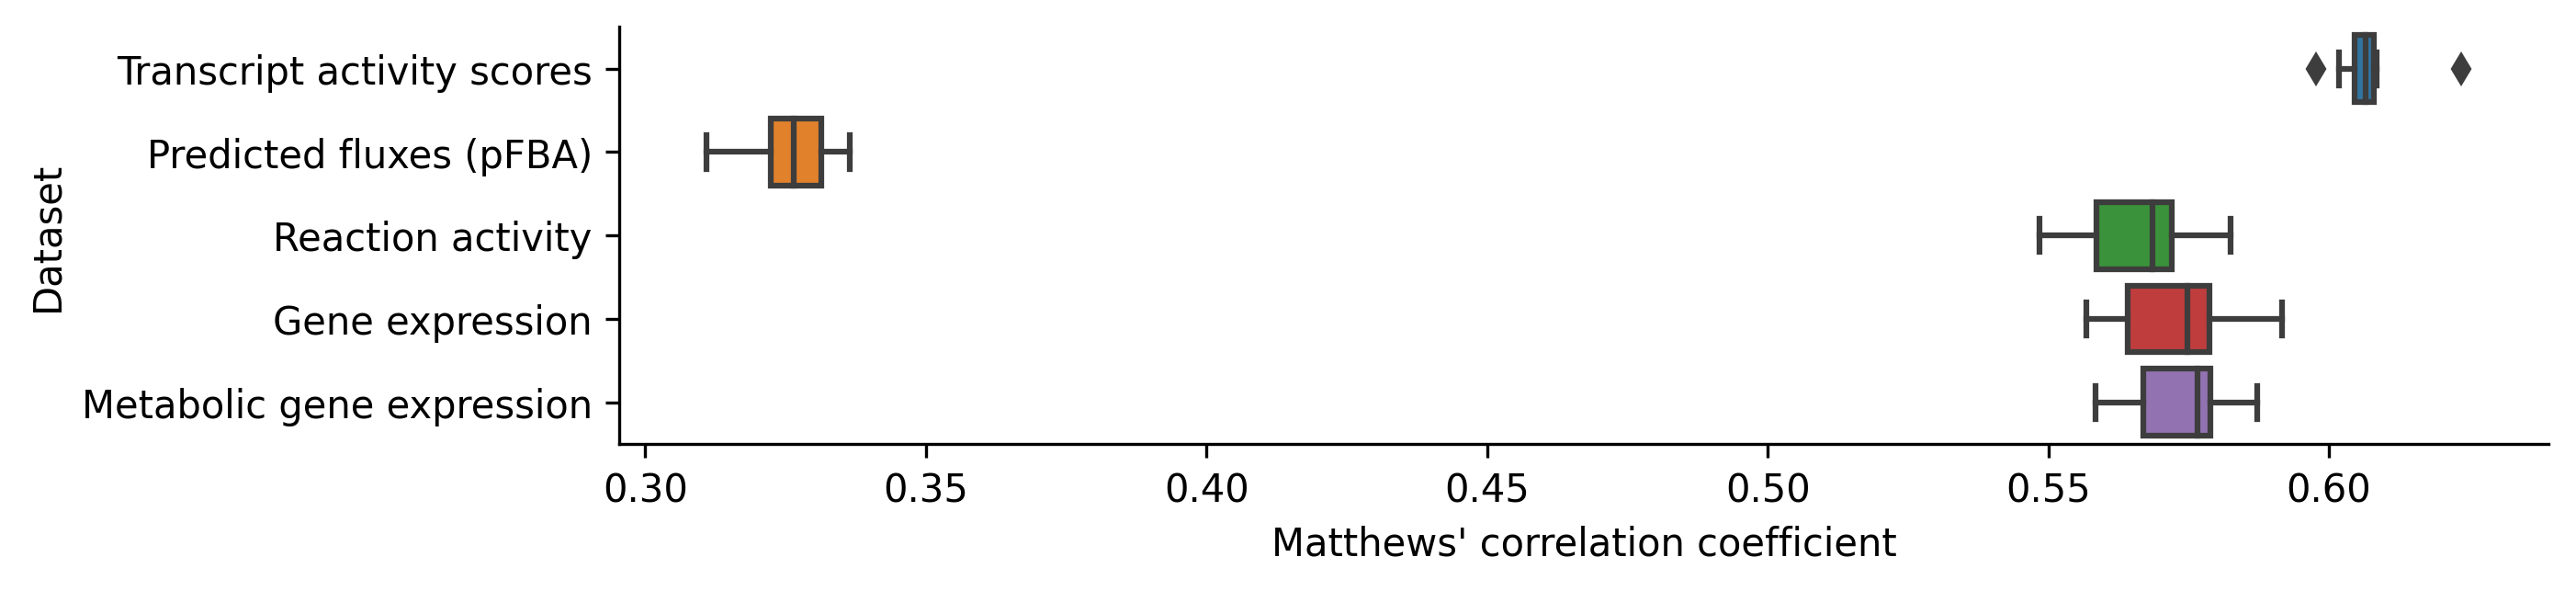

In [74]:
plot_data = model_stats_raw_melt.query('features == 2000 & cvk == 10 & n_estimators == 100 & variable == "mcc_guess"')
plot_data = plot_data.rename(columns={
    'dataset': 'Dataset',
    'value': "Matthews' correlation coefficient"
}).replace({
    'scaled_data': 'Gene expression',
    'scaled_metabolic_data': 'Metabolic gene expression',
    'gene_scores': 'Transcript activity scores',
    'model_simulations': 'Predicted fluxes (pFBA)',
    'reaction_presence': 'Reaction activity'
})

g = sns.catplot(data=plot_data, 
                y='Dataset', x="Matthews' correlation coefficient", aspect=2.5, height=3, kind='box', row='variable')
g.set_titles('')
g.fig.set_dpi(300)
g.fig.set_size_inches(10, 2)
plt.savefig(NB_FOLDER+'/ccle_ml_model_performance.pdf')

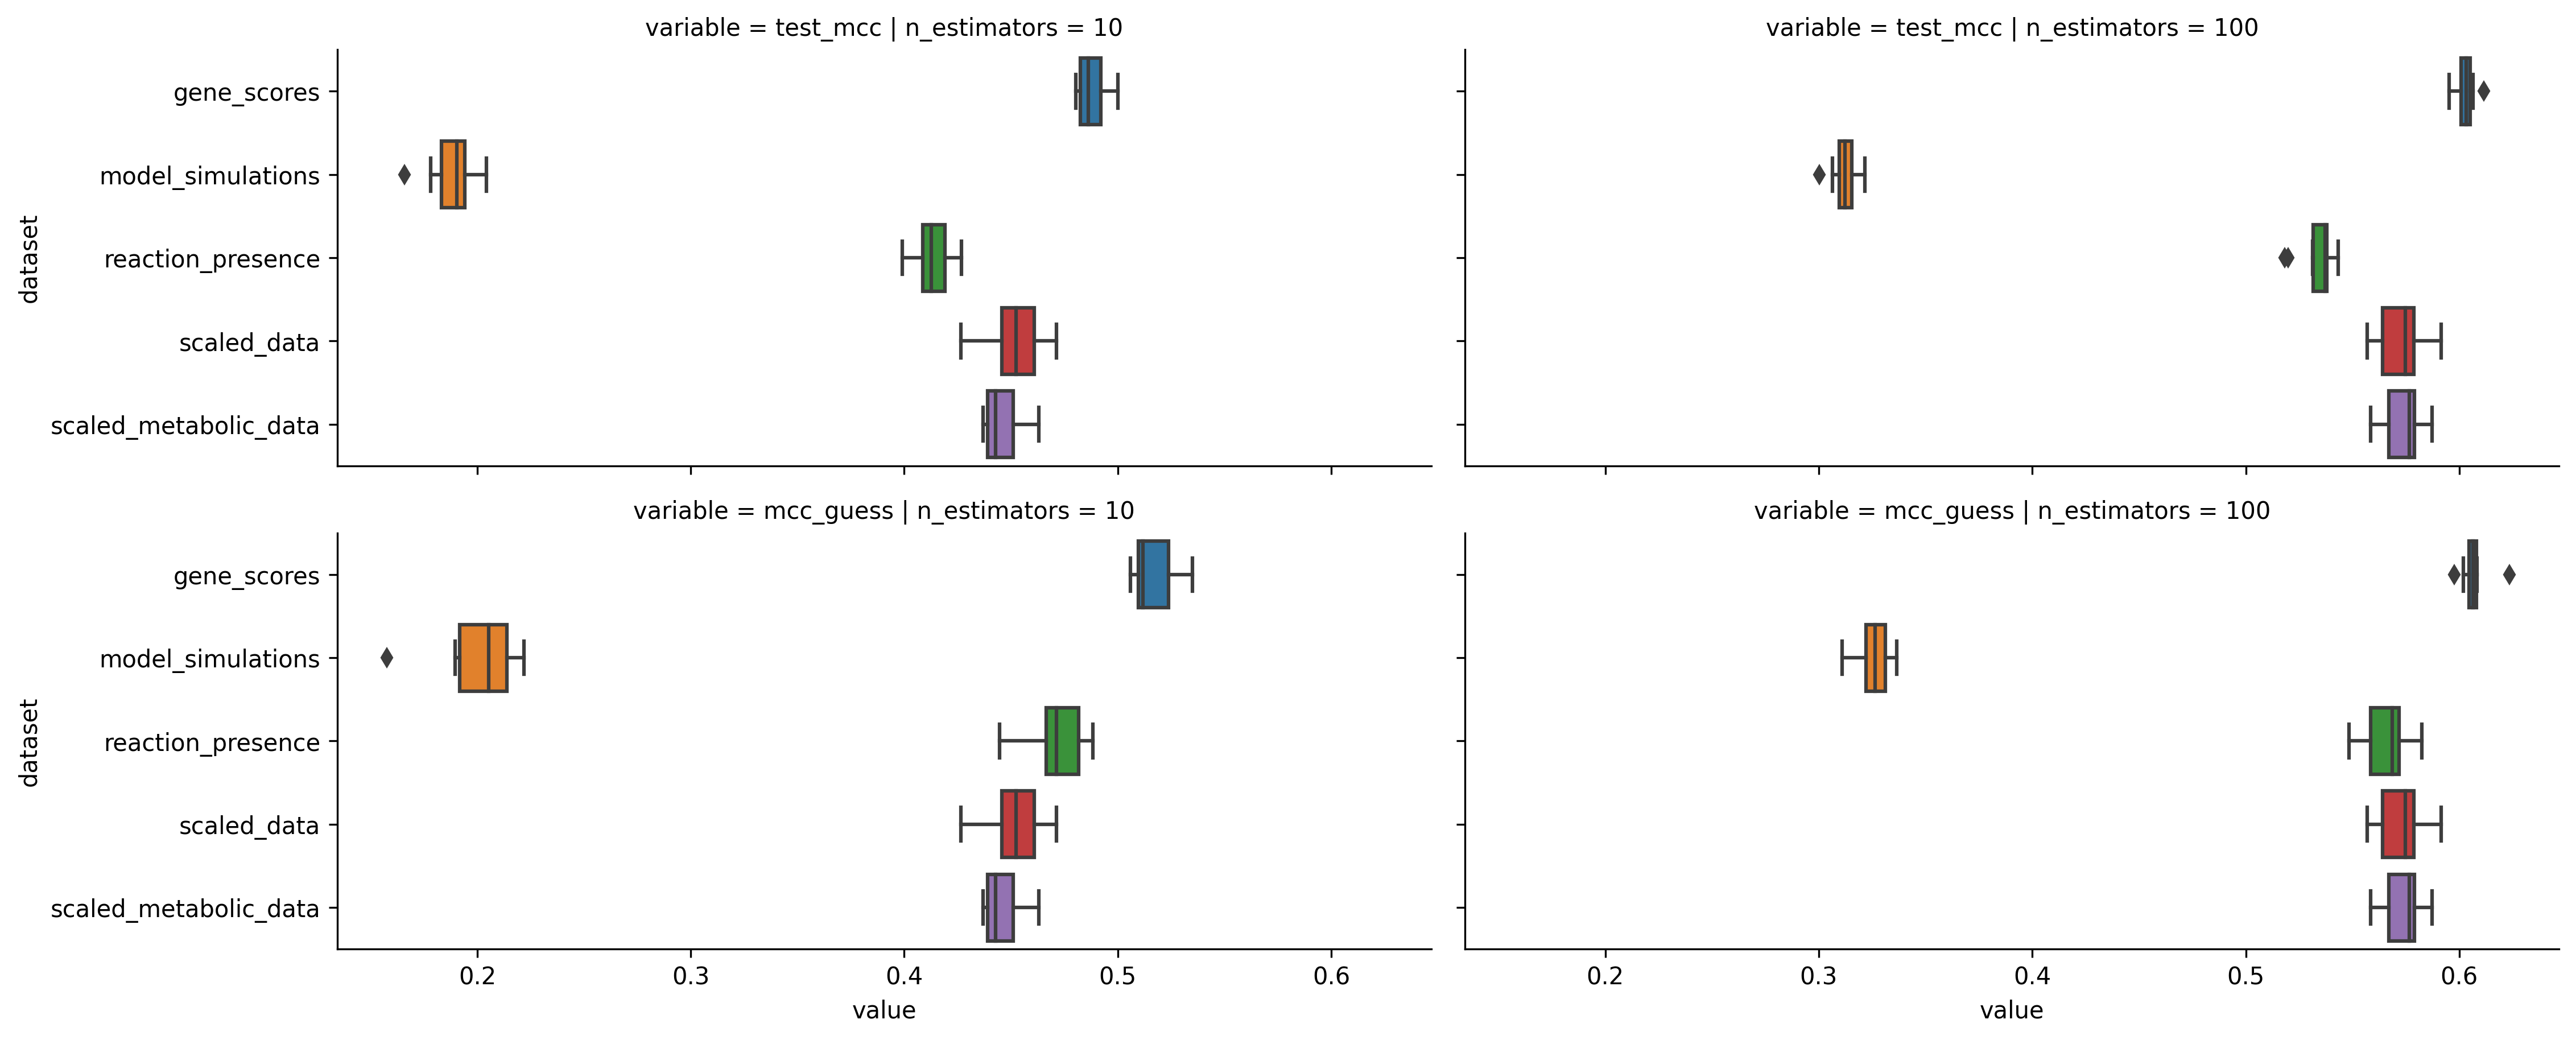

In [77]:
g = sns.catplot(data=model_stats_raw_melt.query('features == 2000 & cvk == 10 & variable in ["test_mcc","mcc_guess"]'), 
                y='dataset', x='value', aspect=2.5, height=3, kind='box', row='variable', col='n_estimators')
g.fig.set_dpi(300)

In [146]:
include_map = (sample_info['disease'].value_counts()/sample_info.shape[0] > 0.01)

In [147]:
ppla = Pipeline([
    ('vt', VarianceThreshold(1e-5)),
#     ('ss', StandardScaler()),
    ('fs', SelectKBest(score_func=f_classif, k=2000)),
    ('clf', RandomForestClassifier(n_estimators=100))
])

mat = scores_df
orig_X = mat.loc[~mat.isna().any(axis=1),:]

X = orig_X.loc[scores_md.index,:]
ppla.fit(X=X, y=scores_md['disease'])

#scores = cross_val_score(ppla ,X=X, y=scores_md['disease'], scoring='f1_weighted', cv=5)
cross_val_scores_df = score_model(clf, X, scores_md['disease'], 5, scorers)
#print('Mean =',scores.mean(),';','SD =',scores.std())

TypeError: score_model() missing 1 required positional argument: 'n_jobs'

In [ ]:
cross_val_scores_df

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
fts = pfba_sims_df_scl.columns[ppl.steps[-3][1].get_support()][ppl.steps[-2][1].get_support()]
{k:bigg_names[k] for k in fts}

In [ ]:
scores

In [ ]:
from scipy.stats import kruskal

In [ ]:
pfba_sims_df_scl.columns

In [ ]:
sample_info[['CCLE_Name','lineage','lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype']]

In [148]:
FLNAME = 'best_params_run_mapall.csv_biomass_gapfill_gapfill_map_essentiality.csv'
model_df_post_essentiality = pd.read_csv(os.path.join(RES_FOLDER,FLNAME), index_col=0)

In [149]:
achilles_gene_effect = pd.read_csv('projects/breast_mcf7/data/ccle/DepMap Public 20Q1/Achilles_gene_effect.csv', 
                                   index_col=0).T

In [150]:
g_cols = [int(g.split('(')[1].replace(')','').strip()) for g in achilles_gene_effect.index]

In [151]:
entrez_genes = hgnc_df['entrez_id'].fillna(-1).astype(int)
entrez_mapper = pd.Series(entrez_genes.index, index=entrez_genes.values, name='entrez_mapping')

In [152]:
achilles_gene_effect['entrez_id'] = g_cols
achilles_gene_effect_entrez = achilles_gene_effect.groupby('entrez_id').mean()

In [153]:
achilles_gene_effect_entrez

ACH-000004  ACH-000005  ACH-000007  ACH-000009  ACH-000011  \
entrez_id                                                               
1            0.179613   -0.085168    0.069931    0.068167    0.283630   
2           -0.199290    0.180624   -0.060810   -0.058659    0.009008   
9            0.163863    0.302175    0.319550    0.096180    0.076868   
10           0.153805    0.355516    0.333941    0.177535    0.097758   
12          -0.029050   -0.317425    0.162516    0.140852    0.174435   
...               ...         ...         ...         ...         ...   
102724473         NaN   -0.168047    0.318108    0.149208   -0.014440   
102724560   -0.175496   -0.173284   -0.019390   -0.063314    0.080413   
105375355    0.297948    0.461276    0.174183    0.372078    0.195667   
107983993    0.027223   -0.248793   -0.169097    0.030491   -0.584397   
110599564   -0.020123    0.023002   -0.046000   -0.049894   -0.214773   

           ACH-000012  ACH-000013  ACH-000014  ACH-000015  ACH-000017  ...  \
entrez_id                                                              ...   
1            0.019812    0.063003    0.149775   -0.074977    0.178831  ...   
2            0.086673   -0.046497    0.009010   -0.191152   -0.070208  ...   
9            0.040905    0.064748    0.104714    0.091762    0.054048  ...   
10           0.103311    0.152990    0.283717   -0.010474    0.230705  ...   
12           0.091279   -0.014310    0.004650    0.112138    0.061985  ...   
...               ...         ...         ...         ...         ...  ...   
102724473    0.222566    0.212797         NaN    0.255296    0.147806  ...   
102724560   -0.167746    0.070717    0.067668   -0.113575   -0.112463  ...   
105375355    0.426725    0.223044    0.237727    0.295070    0.336045  ...   
107983993   -0.135521   -0.021280   -0.210851   -0.085751   -0.074708  ...   
110599564   -0.094049   -0.124165   -0.195362   -0.018881   -0.191794  ...   

           ACH-001960  ACH-001997  ACH-001999  ACH-002001  ACH-002002  \
entrez_id                                                               
1            0.027171    0.165542    0.047263   -0.041440    0.130834   
2           -0.014552   -0.150372    0.044913   -0.045386   -0.166634   
9            0.089054    0.048990    0.183669    0.117743    0.153808   
10           0.116717   -0.143964   -0.104722    0.144221    0.080206   
12           0.061974   -0.046597    0.022301    0.036921   -0.108743   
...               ...         ...         ...         ...         ...   
102724473    0.058180    0.240336    0.083777    0.086718    0.095937   
102724560   -0.086643    0.062994   -0.183978    0.054977    0.052578   
105375355    0.147267    0.126832    0.172214    0.146041    0.214003   
107983993   -0.086946   -0.272743   -0.056777   -0.147716   -0.251402   
110599564   -0.197054   -0.188010   -0.017661   -0.103277   -0.239817   

           ACH-002003  ACH-002004  ACH-002005  ACH-002015  ACH-002204  
entrez_id                                                              
1            0.149141    0.206823    0.296491    0.093116    0.057449  
2           -0.209770   -0.049443    0.144607   -0.186663   -0.237296  
9            0.102874    0.018157   -0.194950    0.038777   -0.343573  
10           0.010664    0.073966    0.336700    0.033732    0.527214  
12           0.241075    0.085144   -0.200482    0.034903    0.277743  
...               ...         ...         ...         ...         ...  
102724473    0.190188    0.057113    0.337143    0.143994    0.217760  
102724560    0.023116   -0.074970    0.007026    0.038808   -0.221813  
105375355    0.413547    0.289074    0.080652    0.089820   -0.179994  
107983993   -0.254609   -0.139006   -0.234998   -0.280938   -0.145965  
110599564   -0.240415   -0.113309   -0.153223    0.024751   -0.266675  

[18333 rows x 739 columns]

In [154]:
entrez_to_ensembl = hgnc_df[['ensembl_gene_id','entrez_id']].set_index('entrez_id',drop=True).dropna()
ess_true_df = achilles_gene_effect_entrez.join(entrez_to_ensembl).set_index('ensembl_gene_id',drop=True).fillna(0)
ess_true_df_nodup = ess_true_df[~ess_true_df.index.duplicated(keep='first')].T
ess_true_df_model_genes = ess_true_df_nodup.T.reindex(model_df_post_essentiality.columns).T

In [155]:
model_df_post_essentiality_perc = (model_df_post_essentiality.T/model_df_post_essentiality.max(axis=1)).T

In [156]:
features = [[k[0],k[2]]+[k[1].split('_')[0], '_'.join(k[1].split('_')[1:])] 
       for k in map(eval, model_df_post_essentiality.index)]
feature_names = ['algorithm','intfunc','cell_line','params']

model_feature_df = pd.DataFrame(features, columns=feature_names)

In [157]:
from sklearn.metrics import f1_score, roc_auc_score, matthews_corrcoef, accuracy_score, precision_score, recall_score

biomass_thresholds = [0.01, 0.1, 0.7, 0.8, 0.9, 0.95, 0.99]
ess_thresholds = [-0.5, -0.75, -1, -1.25, -1.5]

metrics = {
    'f1': f1_score,
    'auc': roc_auc_score,
    'mcc': matthews_corrcoef,
}

In [158]:
res = {}

for bt in biomass_thresholds:
    for et in ess_thresholds:
        Y_true, Y_pred = ess_true_df_model_genes < et, model_df_post_essentiality < bt
        cell_lines = Y_true.index
        for ind in Y_pred.index:
            k = eval(ind)
            feats = [k[0],k[2]]+[k[1].split('_')[0], '_'.join(k[1].split('_')[1:])]
            for mn, func in metrics.items():
                res[tuple([bt,et]+feats+[mn])] = func(Y_true.loc[feats[2],:], Y_pred.loc[ind,:])

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/mi

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900 RuntimeWarning: invalid value encountered in double_scalars
/home/vvieira/mi

In [235]:
features, values = zip(*res.items())

In [245]:
validation_df = pd.DataFrame(features, columns = ['biomass_threshold','effect_threshold']+feature_names+['metric'])
validation_df['value'] = values
validation_df = validation_df.replace({
    'minmax': 'Minimum/Maximum',
    'minsum': 'Minimum/Sum',
    'fastcore': 'FASTCORE',
    'tinit': 'INIT'
})
group_cols = ['biomass_threshold','effect_threshold','metric']

In [246]:
thresholds = [k+'th' for k in ['10','25','50','75','90']]
sty_names = {
    'local1': 'Local 1-state',
    'local2': 'Local 2-state',
    'global': 'Global'
}
def reconvert_names(x):
    sty, g0, g1, l = x.split('_')
    sty = sty_names[sty]
    global_str = 'G='+thresholds[int(g0)]+('-'+thresholds[int(g1)] if sty=='local2' else '')
    local_str =';L='+thresholds[int(l)] if 'Local' in sty else ''
    return sty+': '+global_str+local_str

validation_df['params'] = validation_df['params'].apply(reconvert_names)

In [247]:
validation_df

biomass_threshold  effect_threshold algorithm          intfunc  \
0                    0.01              -0.5  FASTCORE      Minimum/Sum   
1                    0.01              -0.5  FASTCORE      Minimum/Sum   
2                    0.01              -0.5  FASTCORE      Minimum/Sum   
3                    0.01              -0.5  FASTCORE      Minimum/Sum   
4                    0.01              -0.5  FASTCORE      Minimum/Sum   
...                   ...               ...       ...              ...   
674200               0.99              -1.5      INIT  Minimum/Maximum   
674201               0.99              -1.5      INIT  Minimum/Maximum   
674202               0.99              -1.5      INIT  Minimum/Maximum   
674203               0.99              -1.5      INIT  Minimum/Maximum   
674204               0.99              -1.5      INIT  Minimum/Maximum   

         cell_line                        params metric     value  
0       ACH-000004  Local 2-state: G=10th;L=90th     f1  0.318777  
1       ACH-000004  Local 2-state: G=10th;L=90th    auc  0.597471  
2       ACH-000004  Local 2-state: G=10th;L=90th    mcc  0.342067  
3       ACH-000005  Local 2-state: G=10th;L=75th     f1  0.300412  
4       ACH-000005  Local 2-state: G=10th;L=75th    auc  0.589437  
...            ...                           ...    ...       ...  
674200  ACH-002015  Local 1-state: G=50th;L=25th    auc  0.684215  
674201  ACH-002015  Local 1-state: G=50th;L=25th    mcc  0.246310  
674202  ACH-002015  Local 2-state: G=50th;L=50th     f1  0.253731  
674203  ACH-002015  Local 2-state: G=50th;L=50th    auc  0.685378  
674204  ACH-002015  Local 2-state: G=50th;L=50th    mcc  0.256917  

[674205 rows x 8 columns]

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean, tile

In [249]:
mdls = validation_df.query("(biomass_threshold == 0.01) & (effect_threshold == -1.0) & metric == \'mcc\'")

In [250]:
facet_df['algorithm'] + '-' + facet_df['params'] + '-' + facet_df['intfunc']

19265    FASTCORE-Local 2-state: G=10th-Minimum/Sum
19268    FASTCORE-Local 2-state: G=10th-Minimum/Sum
19271    FASTCORE-Local 2-state: G=75th-Minimum/Sum
19274    FASTCORE-Local 2-state: G=10th-Minimum/Sum
19277    FASTCORE-Local 2-state: G=10th-Minimum/Sum
                            ...                    
38513    INIT-Local 2-state: G=10th-Minimum/Maximum
38516    INIT-Local 2-state: G=50th-Minimum/Maximum
38519        INIT-Local 1-state: G=10th-Minimum/Sum
38522    INIT-Local 1-state: G=50th-Minimum/Maximum
38525    INIT-Local 2-state: G=50th-Minimum/Maximum
Length: 6421, dtype: object

In [251]:
facet_df = validation_df.query("(biomass_threshold == 0.01) & (effect_threshold == -0.75) & metric == \'mcc\'")
facet_df.loc[:,'param_combination'] = facet_df['algorithm'] + '-' + facet_df['params'] + '-' + facet_df['intfunc']
model_counts_by_param = facet_df.groupby(['param_combination']).count()['value'].astype(str)
srs = facet_df['param_combination']
srs.index = srs
coverage = ((model_counts_by_param[srs].astype(int)/ess_true_df_model_genes.shape[0])*100).round(1).astype(str)+'%'
facet_df['param_combination'] = (facet_df['param_combination'] + ' ' + coverage).tolist()

/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/pandas/core/indexing.py:844 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/pandas/core/indexing.py:965 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/vvieira/miniconda/envs/cobra36/lib/python3.6/site-packages/ipykernel_launcher.py:7 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



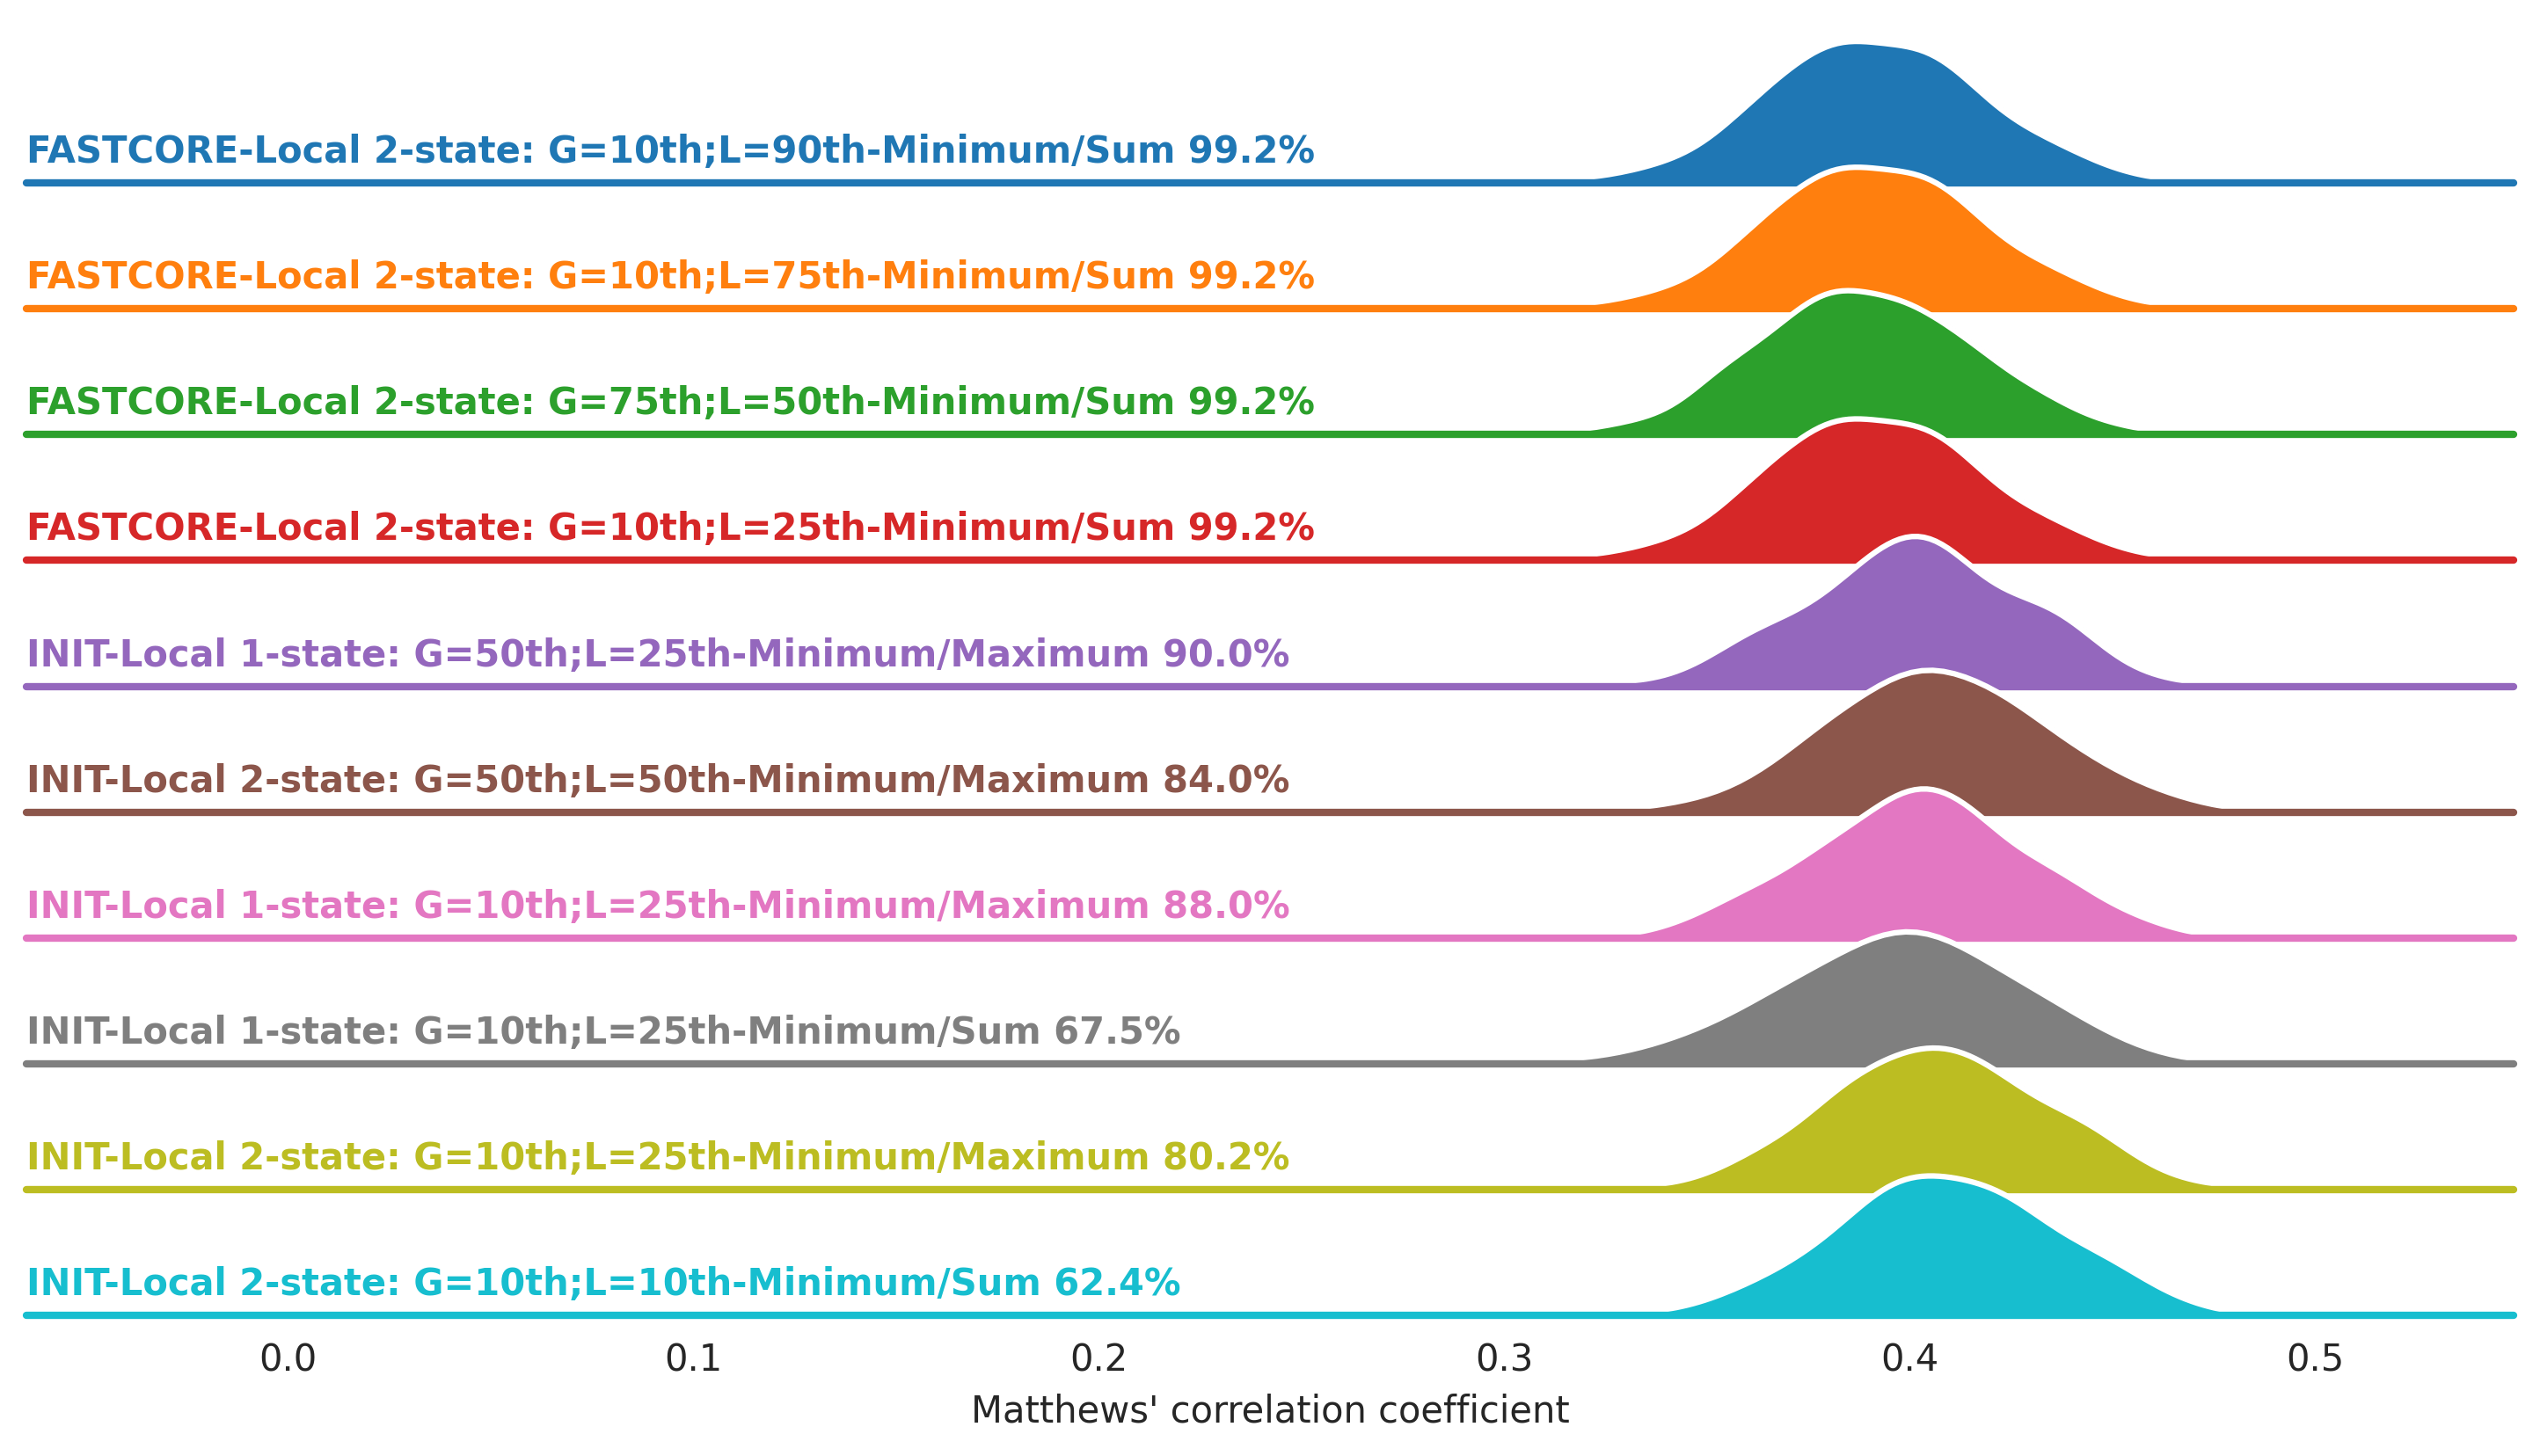

In [260]:
group_var = 'param_combination'
value_var = 'value'

sns.set_style('white', rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(facet_df, aspect=20,row=group_var, hue=group_var,height=.5)

g.map(sns.kdeplot, value_var, clip_on=False, fill=True, alpha=1)
g.map(sns.kdeplot, value_var, clip_on=False, color="w")
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "value")
g.fig.subplots_adjust(hspace=-.20)
g.set_titles("")
g.set(yticks=[])
g.set_xlabels("Matthews' correlation coefficient")
g.despine(bottom=True, left=True)
g.fig.set_dpi(300)
g.fig.set_size_inches(10,6)

plt.savefig(NB_FOLDER+"/ccle_distribution_by_param_comb.pdf")

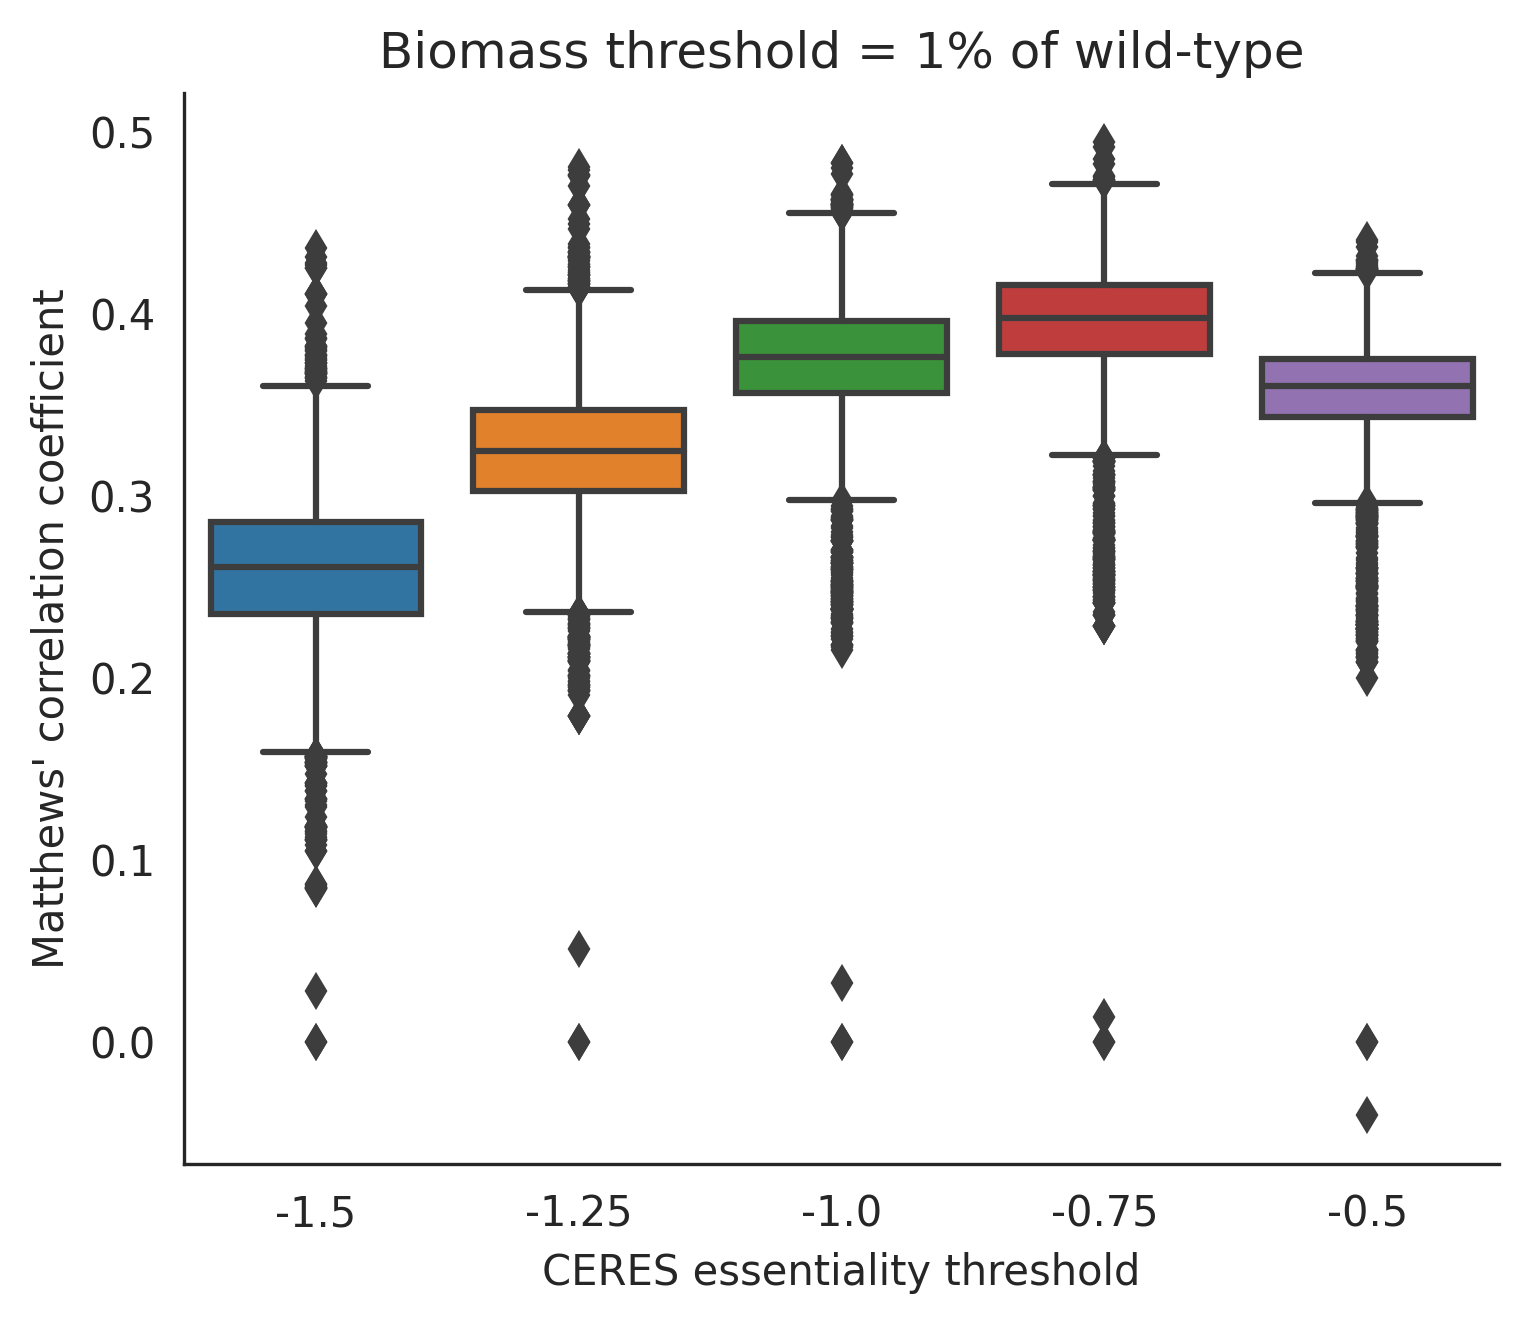

In [261]:
metric = 'mcc'
thr = str(0.01)

data = validation_df.query('biomass_threshold=='+thr+' & metric=='+"'"+metric+"'").drop(columns=['metric','cell_line'])
g = sns.catplot(x='effect_threshold',y='value', data=data, kind='box')
g.fig.axes[0].set_title('Biomass threshold = '+f'{float(thr)*100:.0f}% of wild-type')
g.set_xlabels('CERES essentiality threshold')
g.set_ylabels("Matthews' correlation coefficient")
g.fig.set_size_inches(5, 4)
g.fig.set_dpi(300)

plt.savefig(NB_FOLDER+'/ccle_ge_boxplot_mcc.pdf')

In [262]:
model_df_percs = post_gapfill_percs.groupby('cell_line').mean()
model_df_percs = model_df_percs.loc[:,~(model_df_percs.var() < 0.0001)]

col_to_group = 'disease'
model_df_percs_group = model_df_percs.copy()
model_df_percs_group[col_to_group] = sample_info.loc[model_df_percs.index,:][[col_to_group]]
model_df_percs_group = model_df_percs_group.groupby(col_to_group).mean()

In [263]:
from sklearn.preprocessing import StandardScaler
model_df_percs_grouped_norm = pd.DataFrame(StandardScaler().fit_transform(model_df_percs_group), 
             columns=model_df_percs_group.columns, 
             index=model_df_percs_group.index)

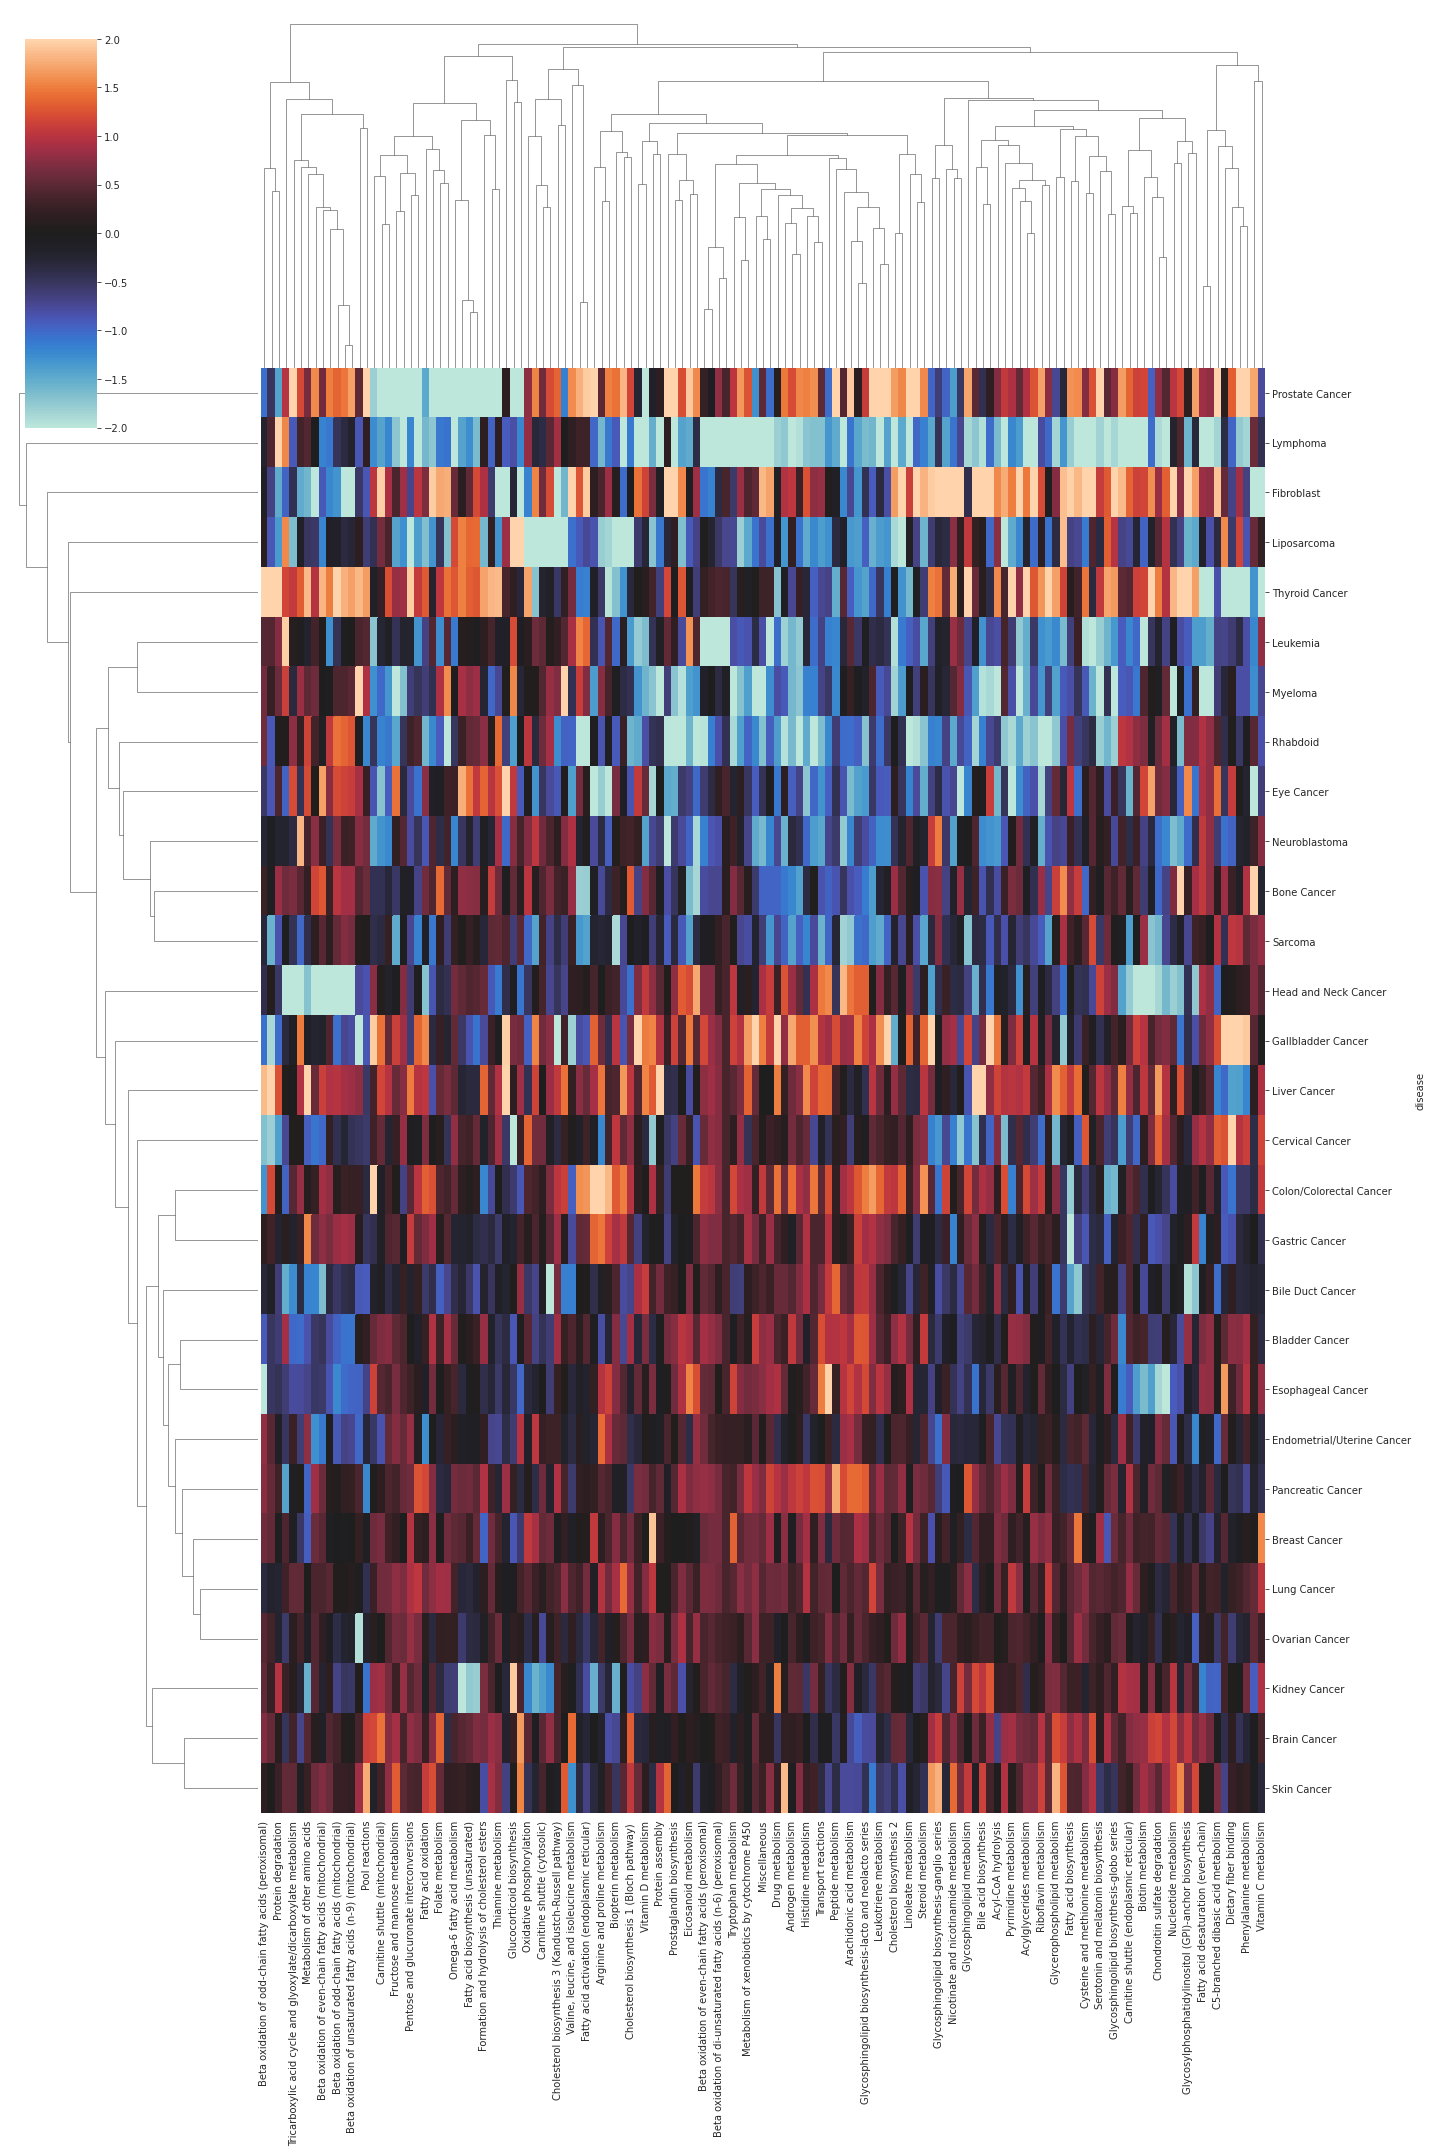

In [199]:
sns.clustermap(model_df_percs_grouped_norm, center=0, figsize=(20,30), vmin=-2, vmax=2)

In [ ]:
post_gapfill_percs